In [1]:
import pandas as pd
import numpy as np

from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
from IPython.display import display
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
print('Packages for Mathematical Computation and visualization imported!')

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

Packages for Mathematical Computation and visualization imported!
Pipeline and preprocessing packages imported!


In [2]:
#house = pd.read_csv('eircodes-all-cols.csv', index_col='Unnamed: 0')
# inflated-prices.csv

house = pd.read_csv('eircodes-all-cols-updated.csv', index_col = 'Unnamed: 0')

In [3]:
house.head()

,Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Quarter,RPPI,PriceInflation,Eircode
0,"Ballinturley, Four Mile House, Roscommon",NaN,Roscommon,46560.0,0,1,1,1,2014,1,Roscommon Town,West,0,Four Mile House Roscommon,Connacht,Other,1,82.0,88123.32,F42
1,"2 Hyde Court, Golf Links Rd, Roscommon",NaN,Roscommon,157000.0,1,1,1,1,2014,1,Roscommon Town,West,0,Golf Links Road Roscommon,Connacht,Estate,1,82.0,297151.22,F42
2,"32 Convent Court, Convent Rd, Roscommon",NaN,Roscommon,56000.0,1,1,1,0,2014,1,Roscommon Town,West,0,Convent Road Roscommon,Connacht,Estate,1,82.0,105990.24,F42
3,"35 Abbeyville, Galway Rd, Roscommon",NaN,Roscommon,125000.0,1,1,1,0,2014,1,Roscommon Town,West,0,Galway Road Roscommon,Connacht,Estate,1,82.0,236585.37,F42
4,"3 The Orchard, The Walk, Roscommon",NaN,Roscommon,106000.0,1,1,1,1,2014,1,Roscommon Town,West,0,The Walk Roscommon,Connacht,Estate,1,82.0,200624.39,F42


### One last piece of cleaning
Forgot to check price of houses at the lower end. We removed houses that had very high prices at the upper end let's do the opposite here.

In [4]:
house.iloc[house['Price (€)'].idxmin()]

Address                      65 St Joseph's Park, Nenagh, Co Tipperary
Postal Code                                                        NaN
County                                                       Tipperary
Price (€)                                                       5080.0
Not Full Market Price                                                1
VAT Exclusive                                                        1
Description of Property                                              1
Property Size Description                                            0
Year                                                              2018
Month                                                                9
Town                                                            Nenagh
Region                                                 South East (IE)
Apartment                                                            0
Neighbourhood                                 St. Joseph's Park Nenagh
Provin

~ €5080 is an incredibly low price for a property sold in Ireland particularly in 2018 when prices were rising strongly again.
We may need to remove some of our values at the lower end, we already did this at the higher end.
We will remove some of these data points at the very lower end, below 30,000€.

In [5]:
house = house[house['Price (€)'] > 30000]

In [6]:
house.drop(columns=['Quarter', 'RPPI', 'Postal Code'], inplace = True)
#house.drop(columns=['Postal Code'], inplace = True)

In [7]:
house1 = house.copy()

In [8]:
house.drop(columns = ['PriceInflation'], inplace = True)

In [9]:
def check_distribution(column, string):

    plt.subplots(figsize=(20, 8))
    sns.distplot(house[column] , fit = norm)
    (mu, sigma) = norm.fit(house[column])
    plt.legend(['mu= {:.2f} & sigma= {:.2f} in normal-dist'.format(mu, sigma)], loc='best', fontsize=13)
    plt.ylabel('Frequency')
    plt.title('Distribution')
    plt.xlabel(string)

### Let's check the distribution of house prices values here first, for unnormalized and normalized values

Distribution of SalePrice before normalization:


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


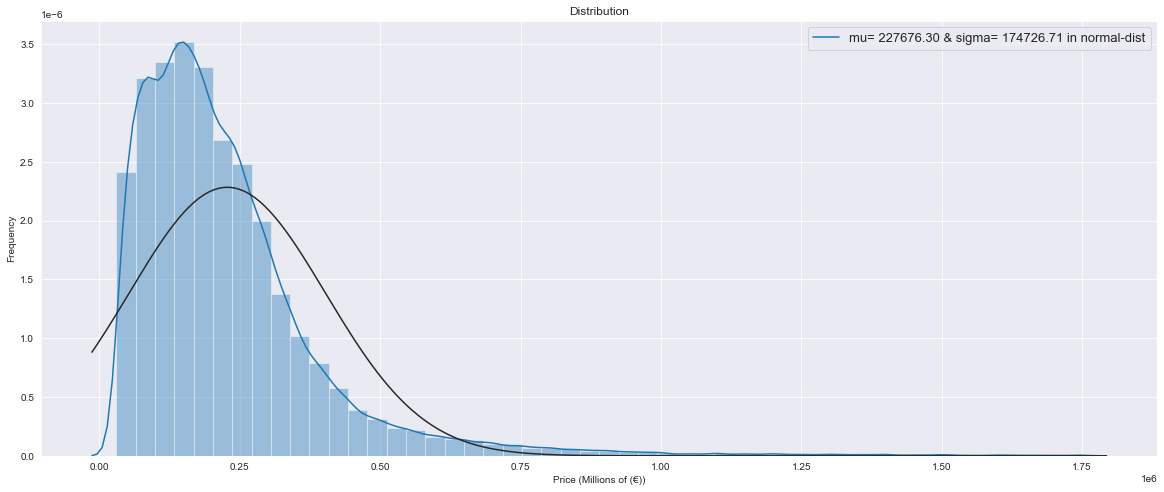

In [10]:
print('Distribution of SalePrice before normalization:')
check_distribution('Price (€)', 'Price (Millions of (€))')

I will now do a frequency plot of the log price sold on houses in Ireland as this is what our experiments will be mainly based on.

Distribution of SalePrice after normalization:


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


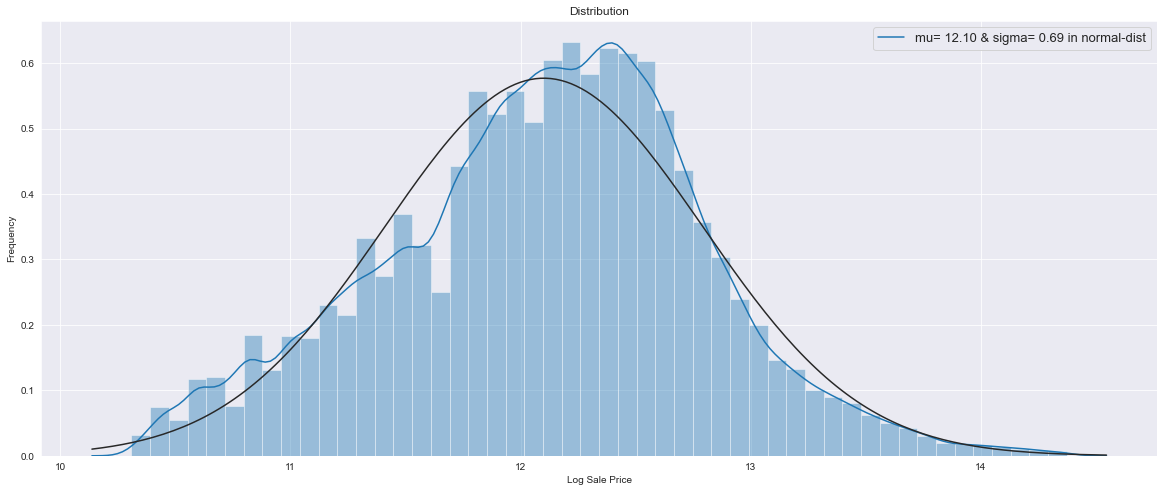

In [11]:
house["SalePrice"] = np.log1p(house["Price (€)"]) 
print('Distribution of SalePrice after normalization:')
check_distribution('SalePrice', 'Log Sale Price')

In [12]:
house.drop(columns=['SalePrice'], inplace=True)

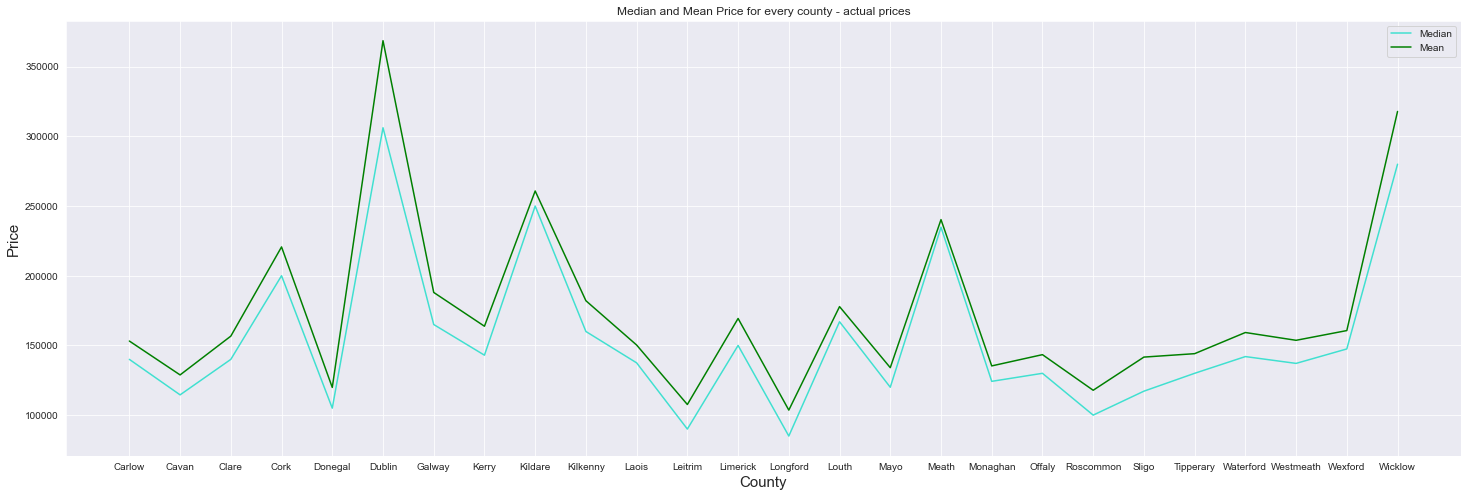

In [13]:
plt.subplots(figsize=(25, 8))
median = plt.plot(house['Price (€)'].groupby(house['County']).median(), label='Median', color='turquoise')
mean = plt.plot(house['Price (€)'].groupby(house['County']).mean(), label='Mean', color='green')
plt.xlabel('County', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.title('Median and Mean Price for every county - actual prices')
plt.legend()
plt.show()

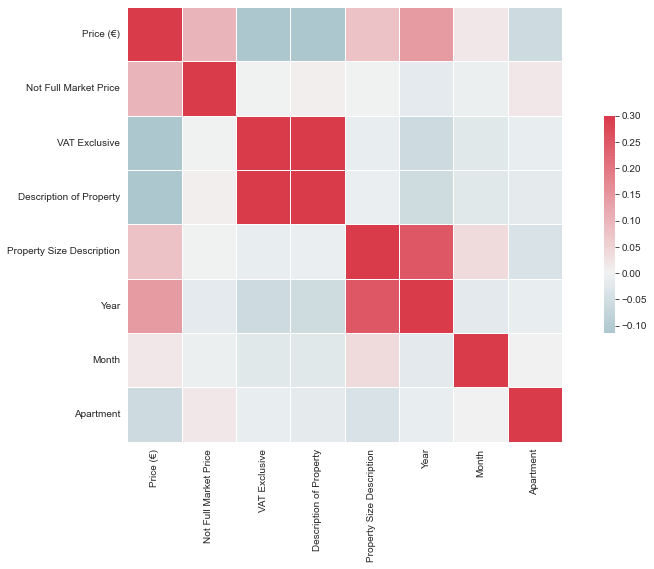

In [14]:
# let's check correlations with our sold price of properties by drawing a heatmap
corrmat = house.corr()
plt.subplots(figsize=(15,8))
cmap = sns.diverging_palette(219, 9, as_cmap=True)

sns.heatmap(corrmat, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

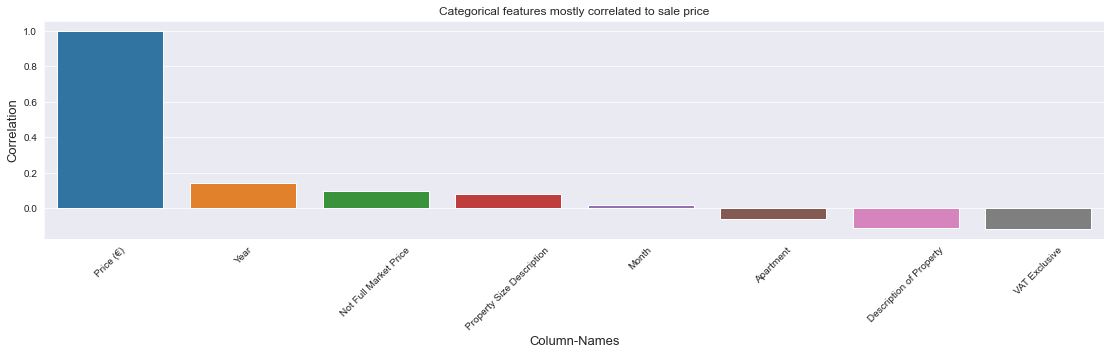

In [15]:
# let's visualize the correlations better using a barchart
cols = house.dtypes[house.dtypes != 'object'].index
corrs=[]
for item in cols:
    corrs.append((house[item].corr(house['Price (€)'])))
    
ist = pd.DataFrame({'cols': cols, 'corrs': corrs})
ist = ist.sort_values(by = 'corrs', ascending = False)
plt.subplots(figsize = (19, 4))
sns.barplot(x = ist['cols'], y = ist['corrs'])
plt.xticks(rotation = 45)
plt.ylabel('Correlation', fontsize = 13)
plt.xlabel('Column-Names', fontsize = 13)
plt.title('Categorical features mostly correlated to sale price')
plt.show()

### Let's convert our categorical variables to numerical values and see the correlations they have with sale price

In [16]:
#house1 = pd.read_csv('adjustments.csv', index_col = 'Unnamed: 0')

In [17]:
from category_encoders import TargetEncoder
encoder = TargetEncoder()
house['Town'] = encoder.fit_transform(house['Town'], house['Price (€)'])

In [18]:
encoder = TargetEncoder()
house['Region'] = encoder.fit_transform(house['Region'], house['Price (€)'])

In [19]:
encoder = TargetEncoder()
house['County'] = encoder.fit_transform(house['County'], house['Price (€)'])

In [20]:
encoder = TargetEncoder()
house['Eircode'] = encoder.fit_transform(house['Eircode'], house['Price (€)'])

In [21]:
encoder = TargetEncoder()
house['Neighbourhood'] = encoder.fit_transform(house['Neighbourhood'], house['Price (€)'])

In [22]:
encoder = TargetEncoder()
house['Province'] = encoder.fit_transform(house['Province'], house['Price (€)'])

In [23]:
house['Estate'] = house['Estate'].map({'Estate': 1, 'Other':0})

In [24]:
house.head()

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Eircode
0,"Ballinturley, Four Mile House, Roscommon",117835.038782,46560.0,0,1,1,1,2014,1,138025.972154,157424.944504,0,123266.317380,151418.281625,0,127743.900185
1,"2 Hyde Court, Golf Links Rd, Roscommon",117835.038782,157000.0,1,1,1,1,2014,1,138025.972154,157424.944504,0,216747.538118,151418.281625,1,127743.900185
2,"32 Convent Court, Convent Rd, Roscommon",117835.038782,56000.0,1,1,1,0,2014,1,138025.972154,157424.944504,0,121222.073690,151418.281625,1,127743.900185
3,"35 Abbeyville, Galway Rd, Roscommon",117835.038782,125000.0,1,1,1,0,2014,1,138025.972154,157424.944504,0,143920.517167,151418.281625,1,127743.900185
4,"3 The Orchard, The Walk, Roscommon",117835.038782,106000.0,1,1,1,1,2014,1,138025.972154,157424.944504,0,153093.772815,151418.281625,1,127743.900185


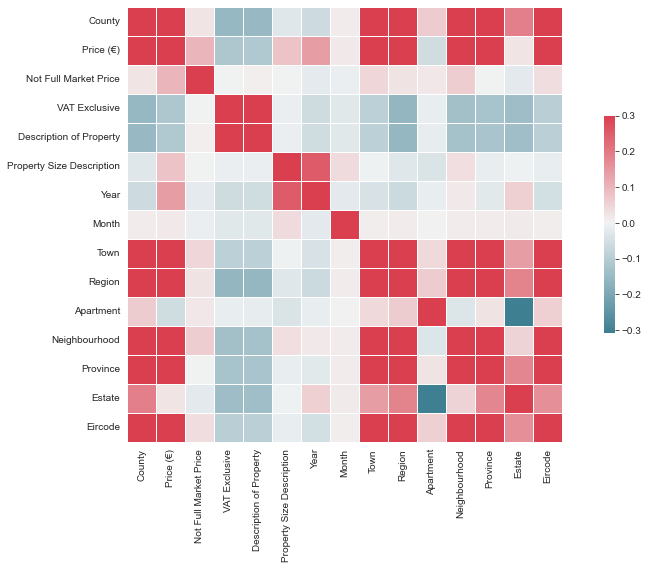

In [25]:
# let's check correlations with our sold price of properties by drawing a heatmap again with all the features this time
corrmat = house.corr()
plt.subplots(figsize=(15, 8))
cmap = sns.diverging_palette(219, 9, as_cmap=True)

sns.heatmap(corrmat, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

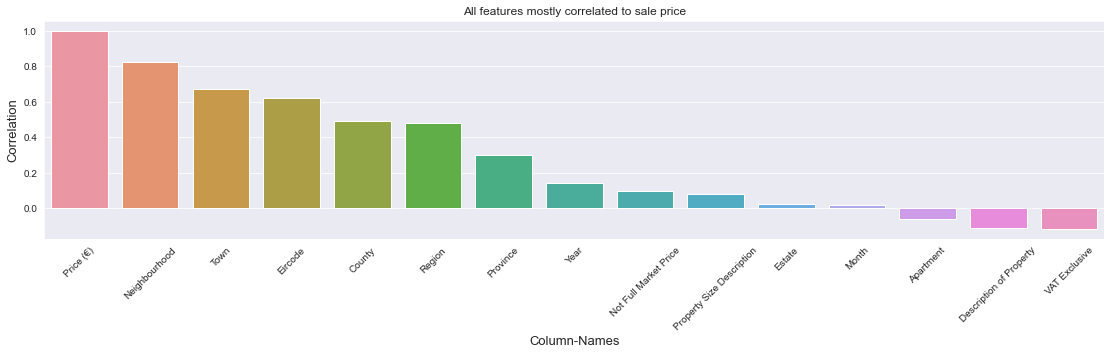

In [26]:
# let's visualize the correlations better using a barchart
cols = house.dtypes[house.dtypes != 'object'].index
corrs=[]
for item in cols:
    corrs.append((house[item].corr(house['Price (€)'])))
    
ist = pd.DataFrame({'cols': cols, 'corrs': corrs})
ist = ist.sort_values(by='corrs', ascending=False)
plt.subplots(figsize=(19, 4))
sns.barplot(x=ist['cols'], y=ist['corrs'])
plt.xticks(rotation=45)
plt.ylabel('Correlation', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('All features mostly correlated to sale price')
plt.show()

The importance of locational attributes on the cost of a house can be seen greatly here.

### Mean and Median prices 2010-2021 in Ireland

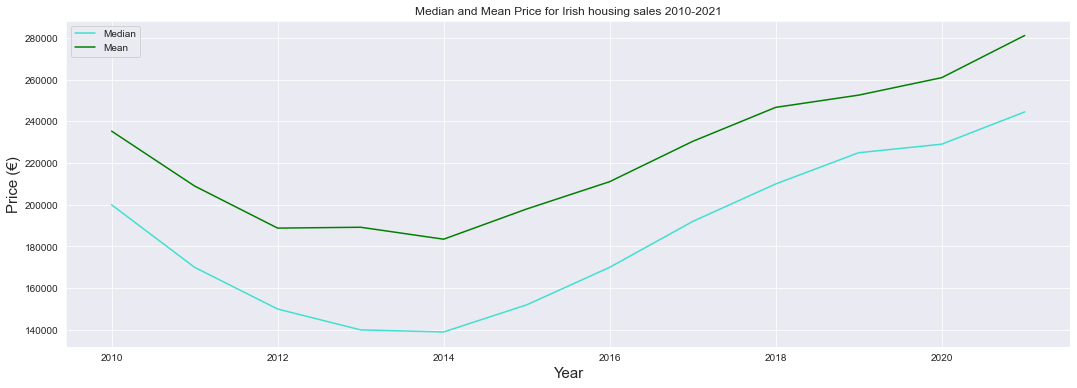

In [27]:
plt.subplots(figsize=(18, 6))
median = plt.plot(house['Price (€)'].groupby(house['Year']).median(), label='Median', color='turquoise')
mean = plt.plot(house['Price (€)'].groupby(house['Year']).mean(), label='Mean', color='green')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price (€)', fontsize=15)
plt.title('Median and Mean Price for Irish housing sales 2010-2021')
plt.legend()
plt.show()

We see a very pronounced dip in mean and median house prices from 2010-2014. This is due to the economic recession from the 2008 financial collapse and was felt keenly until 2013. However, the rise since then has been very sharp and shows no signs of stopping despite factors such as Brexit and the coronavirus pandemic.

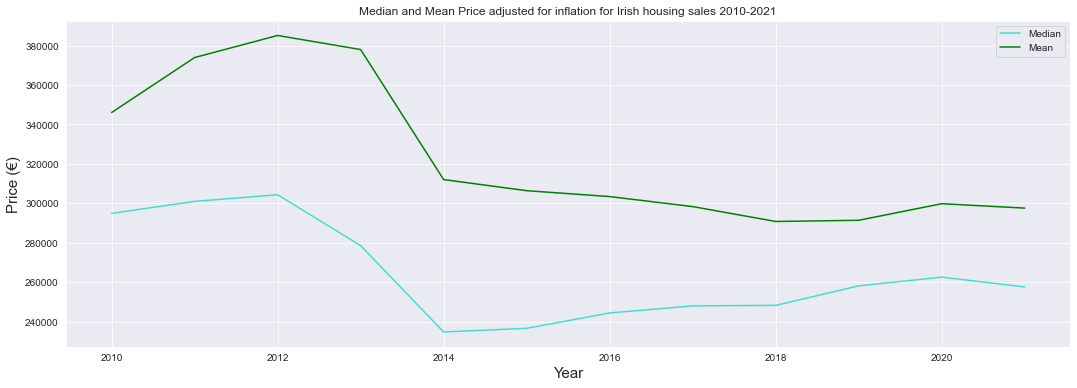

In [28]:
plt.subplots(figsize=(18, 6))
median = plt.plot(house1['PriceInflation'].groupby(house1['Year']).median(), label='Median', color='turquoise')
mean = plt.plot(house1['PriceInflation'].groupby(house1['Year']).mean(), label='Mean', color='green')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price (€)', fontsize=15)
plt.title('Median and Mean Price adjusted for inflation for Irish housing sales 2010-2021')
plt.legend()
plt.show()

### Let's now look into specific towns mean and medians for the same period

In [29]:
grouped_multiple = house1.groupby(['Town']).agg({'Price (€)': ['mean', 'median', 'max']})
grouped_multiple.columns = ['mean', 'med', 'max']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

<AxesSubplot:title={'center':'Irish towns with highest means 2010-2021'}, xlabel='Town/City', ylabel='Price (€))'>

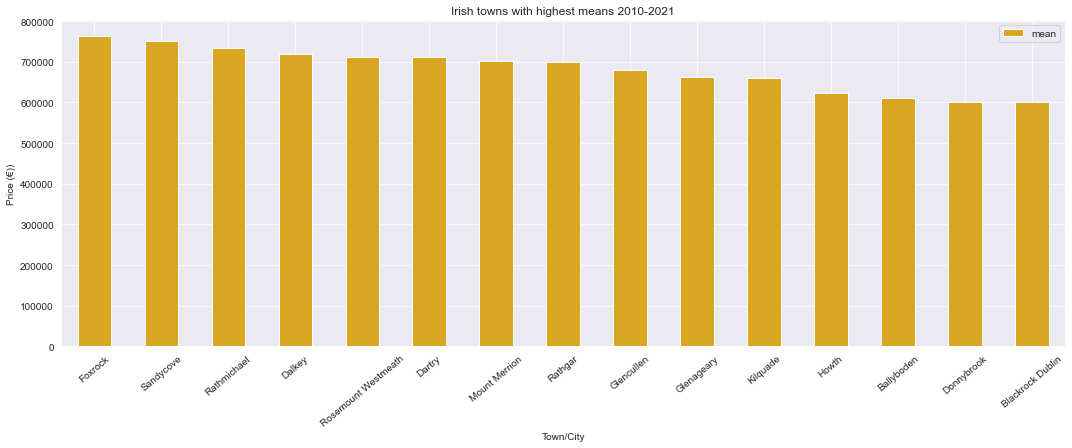

In [30]:
distdf = grouped_multiple.sort_values(by=['mean'], ascending=False).head(15)
distdf.plot.bar(x = 'Town', y = 'mean', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Town/City', ylabel='Price (€))', title='Irish towns with highest means 2010-2021')

Looking at some of the towns/villages here it is hardly surprising that some of these feature at the top. The vast majority of these towns/villages are in what it generally regarded as wealthy areas of Dublin. While some of these may be slightly surprising, these areas may only have a small number of properties sold in them, at higher values, in contrast to other areas and this may skew the mean of these towns as a result.

<AxesSubplot:title={'center':'Irish towns with highest medians 2010-2021'}, xlabel='Town/City', ylabel='Price (€))'>

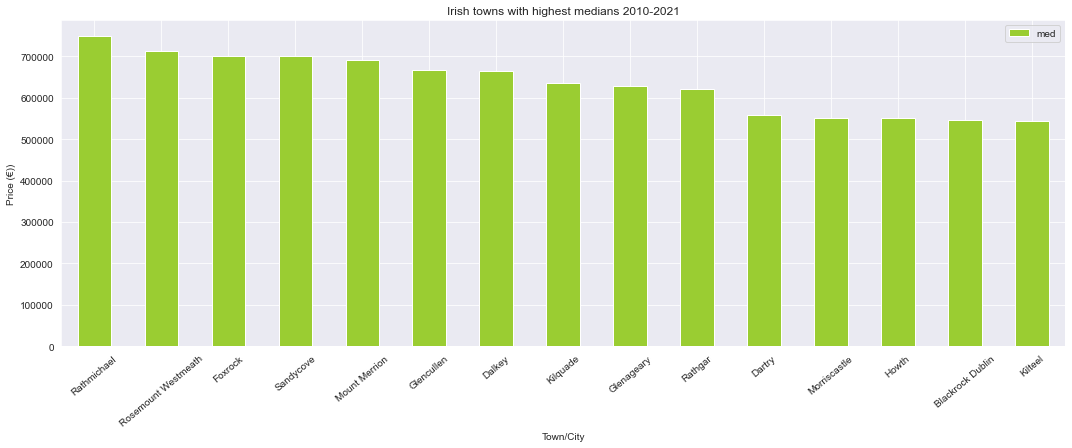

In [31]:
distdf = grouped_multiple.sort_values(by=['med'], ascending=False).head(15)
distdf.plot.bar(x = 'Town', y = 'med', rot = 40, figsize=(18, 6), color='yellowgreen', xlabel='Town/City', ylabel='Price (€))', title='Irish towns with highest medians 2010-2021')

There is much the same towns here in the median prices for a town/village as there are for our means. The order is slightly different. The medians are very high here looking at the scaling on our charts in contrast to our nationwide approach the median in 2021 was approximately 250,000€ whereas the lowest median here was over 500,000€. It is very interesting to note how highly Rosemount in Co.Westmeath is within the most pricy towns/areas here. Rosemount would not be regarded as more expensive to live in than let's say Blackrock Co.Dublin but our mean and medians suggest otherwise here.

### Let's do the same at a region based level
There is normally quite a disparity in prices between the west of Ireland and the greater Dublin region, let's see if this is true here for our cleaned data.

In [32]:
grouped_multiple_1 = house1.groupby(['Region']).agg({'Price (€)': ['mean', 'median', 'max']})
grouped_multiple_1.columns = ['mean', 'med', 'max']
grouped_multiple_1 = grouped_multiple_1.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple_1 = pd.DataFrame(grouped_multiple_1)

<AxesSubplot:title={'center':'Irish regions by means 2010-2021'}, xlabel='Region', ylabel='Price (€))'>

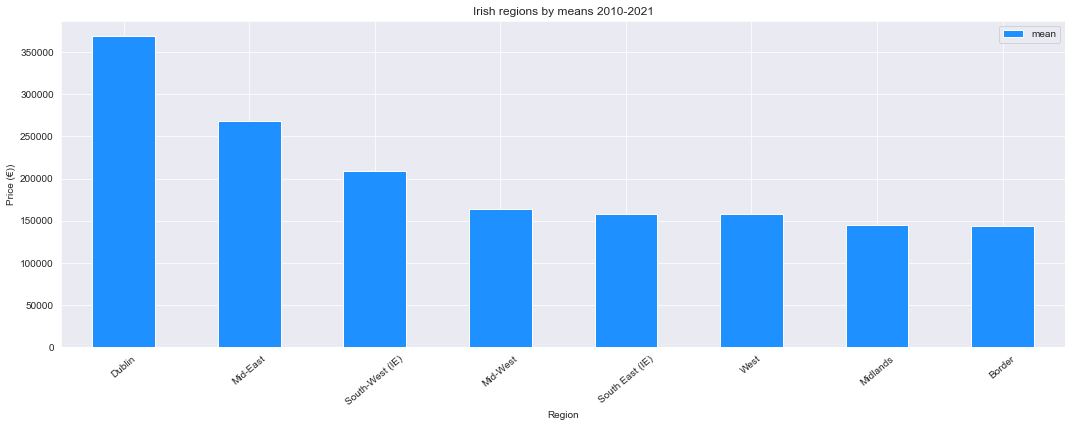

In [33]:
distdf_1 = grouped_multiple_1.sort_values(by=['mean'], ascending=False)
distdf_1.plot.bar(x = 'Region', y = 'mean', rot = 40, figsize=(18, 6), color='dodgerblue', xlabel='Region', ylabel='Price (€))', title='Irish regions by means 2010-2021')

It is no surprise that Dublin and the Mid-East regions have much higher means than the rest of the regions. The mid-east region consists of what would be regarded as the "Pale" which covers counties Meath and Kildare and also covers county Wicklow. These typically commuter-based counties normally command higher prices due to their proximity to Dublin. It was interesting to note that the west of Ireland region was actually around the middle here, albeit with very little to seperate it and regions with slightly lower means. It must be said the regions are denoted maybe slightly differently to how we see them. The west here consists of only Galway, Mayo and Roscommon here whereas other people may also include Sligo in this among others. This is because I followed the regions as they were denoted by a geocoding library used on the Irish property register data from 2012-2017.

<AxesSubplot:title={'center':'Irish regions by medians 2010-2021'}, xlabel='Region', ylabel='Price (€))'>

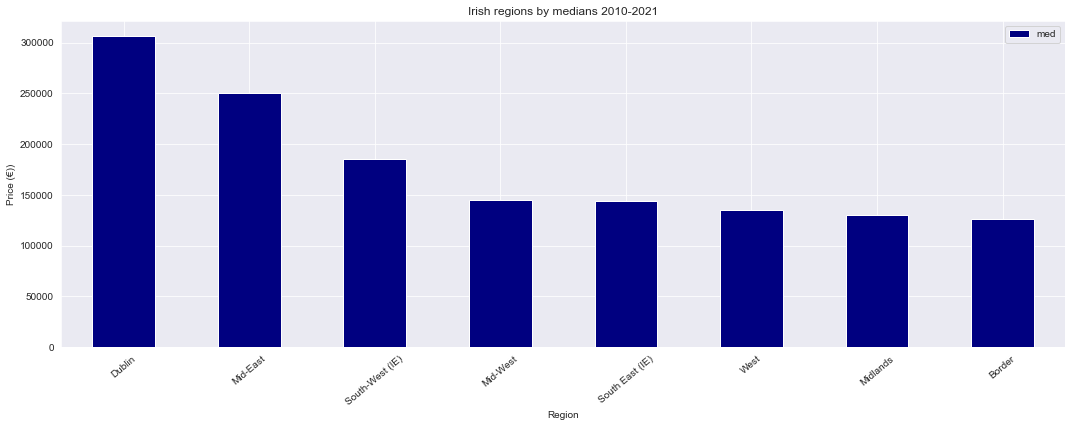

In [34]:
distdf_1 = grouped_multiple_1.sort_values(by=['med'], ascending=False)
distdf_1.plot.bar(x = 'Region', y = 'med', rot = 40, figsize=(18, 6), color='navy', xlabel='Region', ylabel='Price (€))', title='Irish regions by medians 2010-2021')

Again, we see similar results regarding the means of properties sold in each region with the Dublin, mid-east and south-west the clear top three in this specific order. While the order of our other regions is changed they share comparably low medians to the top three aforementioned regions, all slightly below the 150,000€ median mark.

In [35]:
grouped_multiple_1 = house1.groupby(['Neighbourhood']).agg({'Price (€)': ['mean', 'median', 'max']})
grouped_multiple_1.columns = ['mean', 'med', 'max']
grouped_multiple_1 = grouped_multiple_1.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple_1 = pd.DataFrame(grouped_multiple_1)

<AxesSubplot:title={'center':'Irish neighbourhoods by means 2010-2021'}, xlabel='Neighbourhood', ylabel='Price (Millions Euro)'>

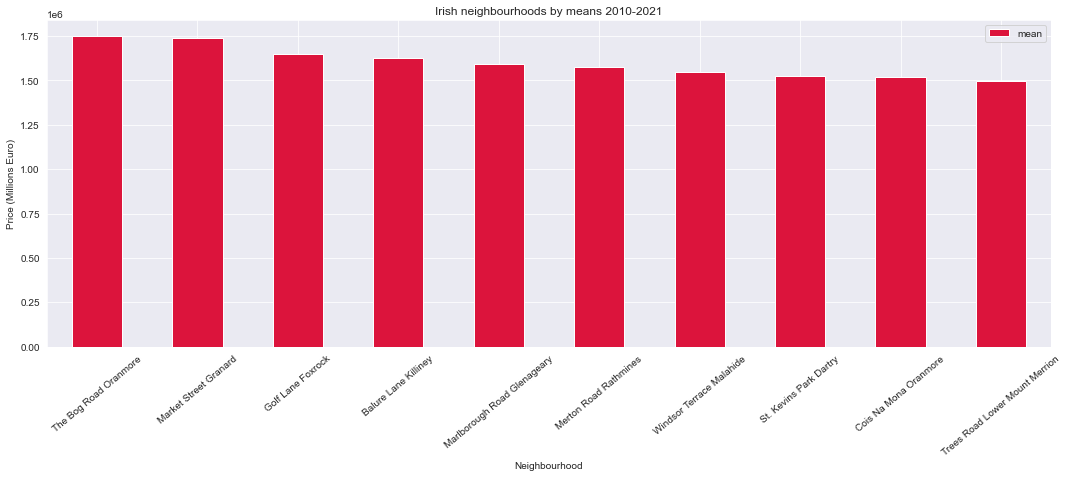

In [36]:
distdf_1 = grouped_multiple_1.sort_values(by=['mean'], ascending=False)[:10]
distdf_1.plot.bar(x = 'Neighbourhood', y = 'mean', rot = 40, figsize=(18, 6), color='crimson', xlabel='Neighbourhood', ylabel='Price (Millions Euro)', title='Irish neighbourhoods by means 2010-2021')

It is interesting to note that two of the top 10 are from Oranmore, Co. Galway which you would not expect given it is i) from the west of Ireland and ii) not based in Dublin. It goes to show that some of our presumptions about our data i.e. higher prices geared towards Dublin, "the Pale" etc may not be as correct as we thought.

In [37]:
grouped_multiple_1 = house1.groupby(['Eircode']).agg({'Price (€)': ['mean', 'median', 'max']})
grouped_multiple_1.columns = ['mean', 'med', 'max']
grouped_multiple_1 = grouped_multiple_1.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple_1 = pd.DataFrame(grouped_multiple_1)

<AxesSubplot:title={'center':'Irish eircodes by means 2010-2021'}, xlabel='Eircodes', ylabel='Price (Thousands €)'>

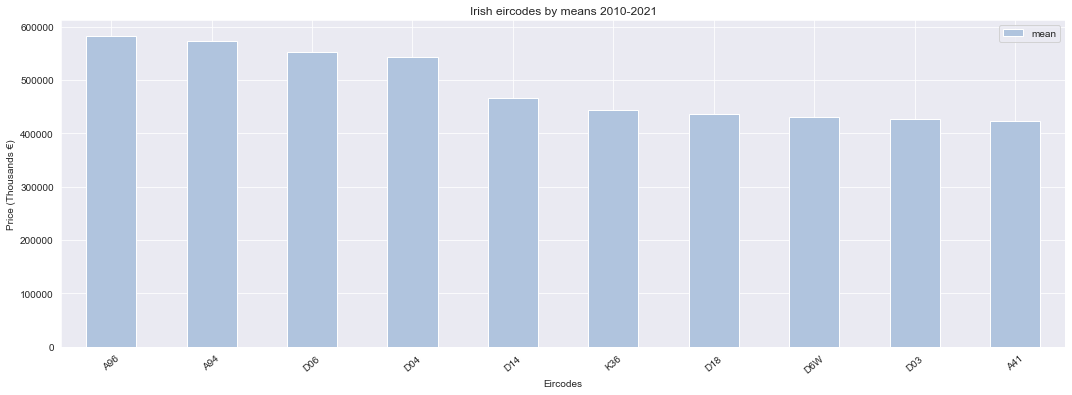

In [38]:
distdf_1 = grouped_multiple_1.sort_values(by=['mean'], ascending=False)[:10]
distdf_1.plot.bar(x = 'Eircode', y = 'mean', rot = 40, figsize=(18, 6), color='lightsteelblue', xlabel='Eircodes', ylabel='Price (Thousands €)', title='Irish eircodes by means 2010-2021')

### Overview of these findings
Looking at our average prices per eircode in our data, the results are hardly surprising. Just taking a look at our top 5 highest means these are all based in stereotypically affulent areas of Dublin. One of the theories I have seen in my literature review is that Irish people will certainly pay for the names on their address and this certainly stands true here.

In [39]:
#house.loc[house['Eircode'] == 'A96']
#house.loc[house['Eircode'] == 'D14']

### Let's check how many properties were sold in each year
As per our cleaned data which included removing duplicates and poorly inputted addresses there are over 370,000 properties sold, so let's look into this now.

<AxesSubplot:title={'center':'Number of properties sold each year in Ireland 2010-2021'}>

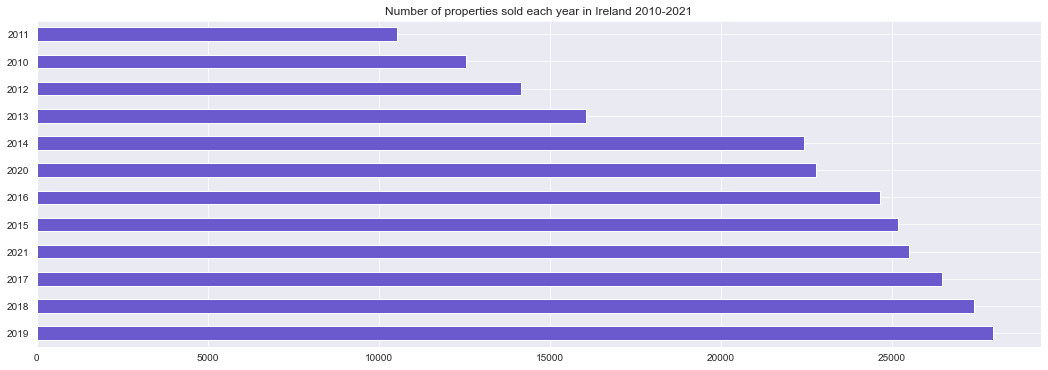

In [173]:
house['Year'].value_counts().plot(kind='barh', figsize=(18,6), color='slateblue',
                                 title='Number of properties sold each year in Ireland 2010-2021')

It is interesting to note here that even though our data only covers approximately 3/4 of 2021 that it has more properties sold than in 2010, 2011, 2012 and 2013. We also see that despite being in and out of harsh lockdowns in 2020 far more properties were sold then in contrast to the aforementioned years. This certainly highlights the significant financial constraints due to the global recession of the time the population faced. This graphic also suggests, along with our mean and median graph from earlier, that the less properties sold the lower the mean and medians for the year which I feel shows that cheaper properties sold to a larger extent in these recession times. It would be interesting to look at some economic factors such as GDP along with our housing data among others here.

### Let's check how many properties were deemed to be sold at "Full Market Price"

<AxesSubplot:title={'center':'Number of properties sold at full market price in Ireland 2010-2021'}>

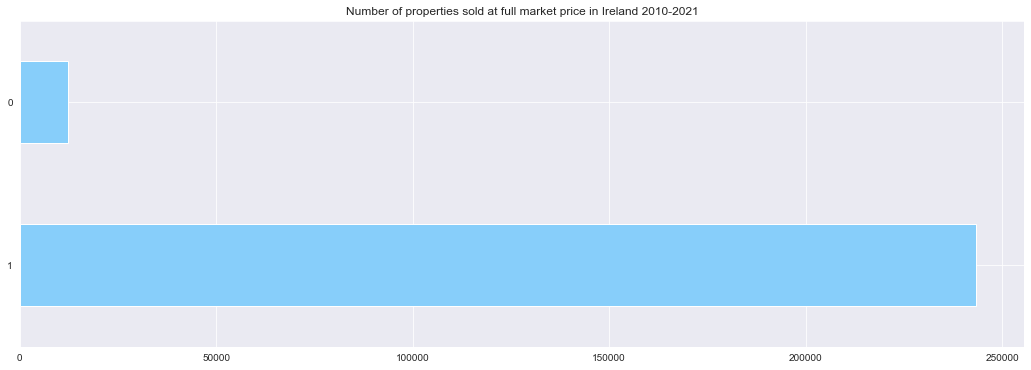

In [41]:
house['Not Full Market Price'].value_counts().plot(kind='barh', figsize=(18,6), color='lightskyblue',
                                 title='Number of properties sold at full market price in Ireland 2010-2021')

There were very few properties sold at what is regarded as below their actual selling price. It might be interesting to delve a bit deeper into this and see if years where prices were cheaper had more "bargains" to be had.

Text(0, 0.5, 'Number of properties')

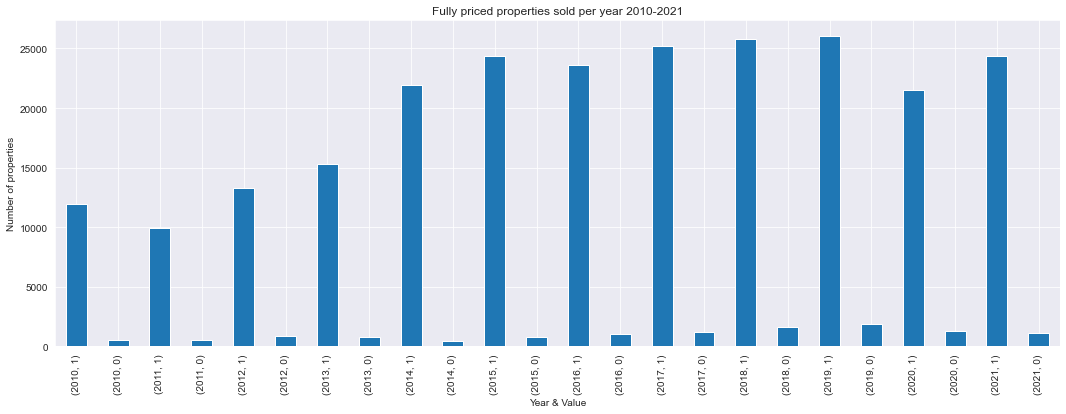

In [42]:
plotdata = house['Not Full Market Price'].groupby(house['Year']).value_counts()
plotdata.plot(kind="bar", figsize=(18,6))
plt.title("Fully priced properties sold per year 2010-2021")
plt.xlabel("Year & Value")
plt.ylabel("Number of properties")

There seems to be no real correlation between a lower number of properties sold and the number of properties sold below market value here.

### Let's check box plot for Apartments Vs Price

Text(0.5, 1.0, 'Apartment Y/N')

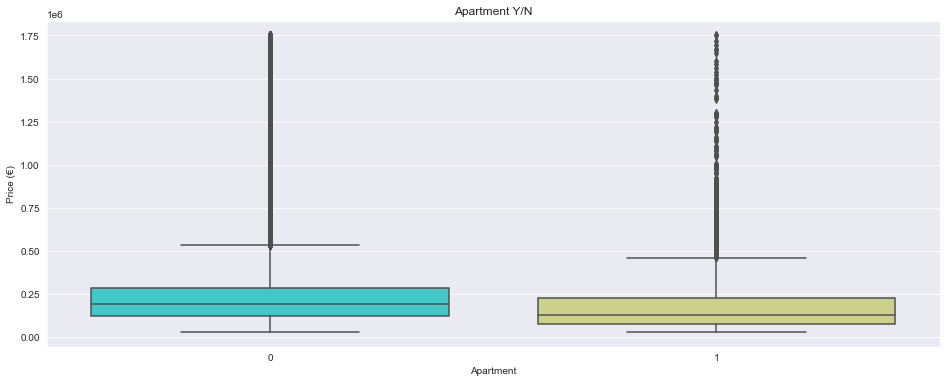

In [43]:
plt.figure(figsize=(16,6))
sns.boxplot(x = 'Apartment', y = 'Price (€)', data = house1, palette='rainbow')
plt.title("Apartment Y/N")

Text(0.5, 1.0, 'Is in estate Y/N')

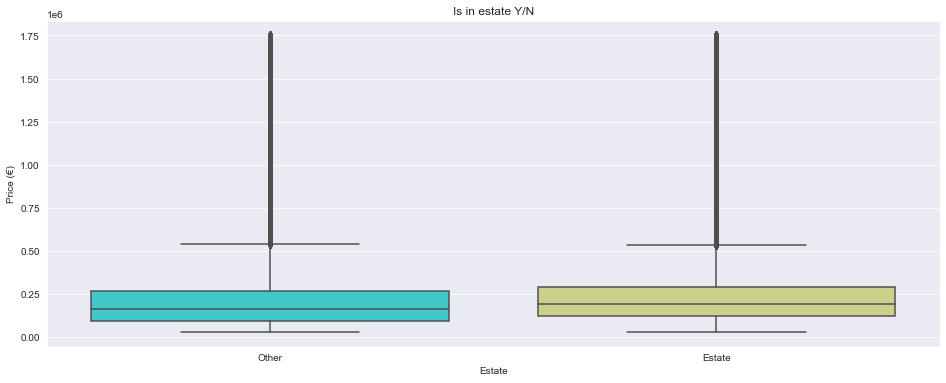

In [44]:
## let's do the same for estates
plt.figure(figsize=(16,6))
sns.boxplot(x = 'Estate', y = 'Price (€)', data = house1, palette='rainbow')
plt.title("Is in estate Y/N")

### Let's now do a cat plot to check distribution of sold prices within each county

In [45]:
mean_national = house1['Price (€)'].mean()

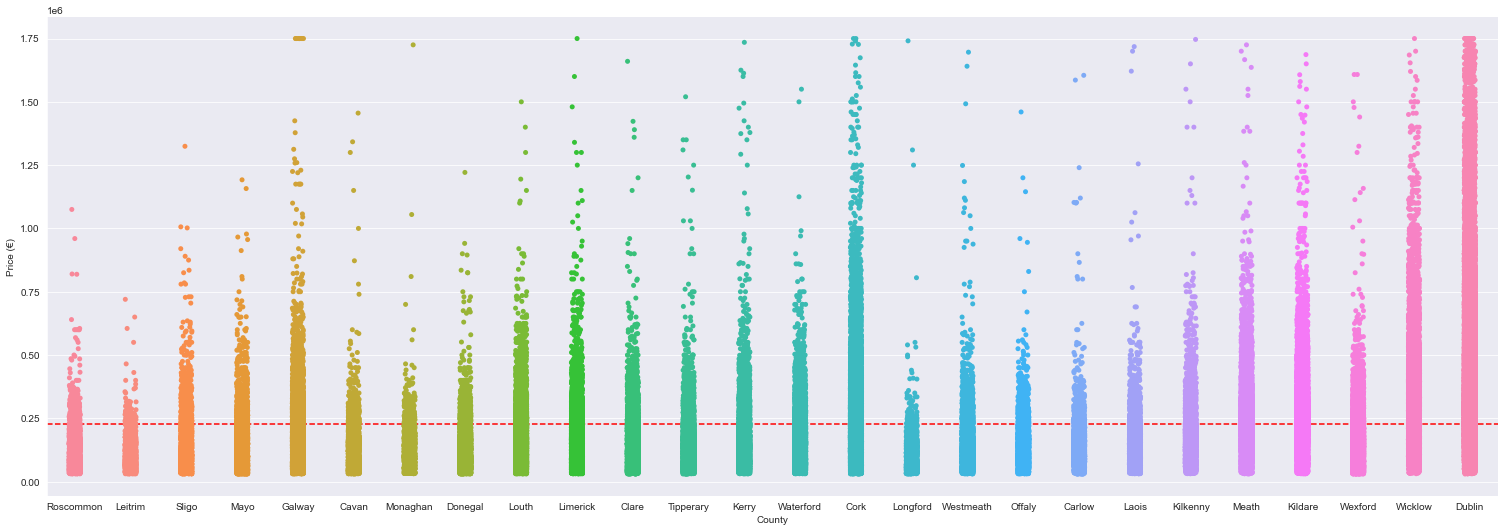

In [46]:
g = sns.catplot(x = 'County', y = 'Price (€)', data = house1)
g.map(plt.axhline, y = mean_national, ls='--', c='red')
g.fig.set_figheight(8)
g.fig.set_figwidth(25)

Taking out Dublin and Cork here which possess the two biggest cities and two biggest county-based populations, we see Wicklow, Kildare and Meath seem to possess a higher proportion of houses at the higher end.

## How we are adjusting for inflation

As per the [CSO](https://www.cso.ie/en/methods/surveybackgroundnotes/residentialpropertypriceindex/), the residential property price index helps capture changes in price over time due to the market and inflation. I will now attempt to apply this to my data. The formula can be defined as follows for adjusting prices acccording to RPPI:

***Price in previous year x (Current RPPI / Previous RPPI)   =   New Price***

The current RPPI will be based on the latest value in our data which is for Q3 2021 to adjust prices as accurately as we can. I simply took the nationwide RPPI and applied it across the board. Regional data exists only as far back as Q3 2016 for RPPI values.

Example of how RPPI is used to calculate current market value:
Consider a house sold in South Dublin in June 2010 for €220,000.

      South Dublin house price index June 2010:                           88.9

      South Dublin house price index currently:                            121.5

      Estimated current value:                                                      €220,000 x (121.5 / 88.9)   =   €300,675

***NOTE*** Done in other file.

In [47]:
grouped_county = house1.groupby(['County','Year']).agg({'PriceInflation':'mean', 'Price (€)': 'mean'}).reset_index()

In [48]:
counties = list(set(grouped_county['County']))

In [49]:
d = {}
# 2013 as this was nadir 
for i in range(len(counties)):
    maxv = grouped_county.loc[(grouped_county['County'] == counties[i]) & (grouped_county['Year'] == 2021) ,'PriceInflation'].item()
    minv = grouped_county.loc[(grouped_county['County'] == counties[i]) & (grouped_county['Year'] == 2014) ,'PriceInflation'].item()
    change =  maxv - minv
    d[counties[i]] = change

In [50]:
changes = pd.DataFrame.from_dict(d, orient='index')
#changes = changes.reset_index()
changes = changes.rename(columns={0: 'Change'})

In [51]:
changes['positive'] = changes['Change'] > 0

In [52]:
d1 = {}
# 2013 nadir normal price, 2014 nadir adjusted prices
for i in range(len(counties)):
    maxv = grouped_county.loc[(grouped_county['County'] == counties[i]) & (grouped_county['Year'] == 2021) ,'Price (€)'].item()
    minv = grouped_county.loc[(grouped_county['County'] == counties[i]) & (grouped_county['Year'] == 2014) ,'Price (€)'].item()
    change =  maxv - minv
    d1[counties[i]] = change

In [53]:
changes1 = pd.DataFrame.from_dict(d1, orient='index')
#changes = changes.reset_index()
changes1 = changes1.rename(columns={0: 'Change'})
changes1['positive'] = changes1['Change'] > 0

<AxesSubplot:title={'center':'Mean price changes in property per county 2014 - 2021'}>

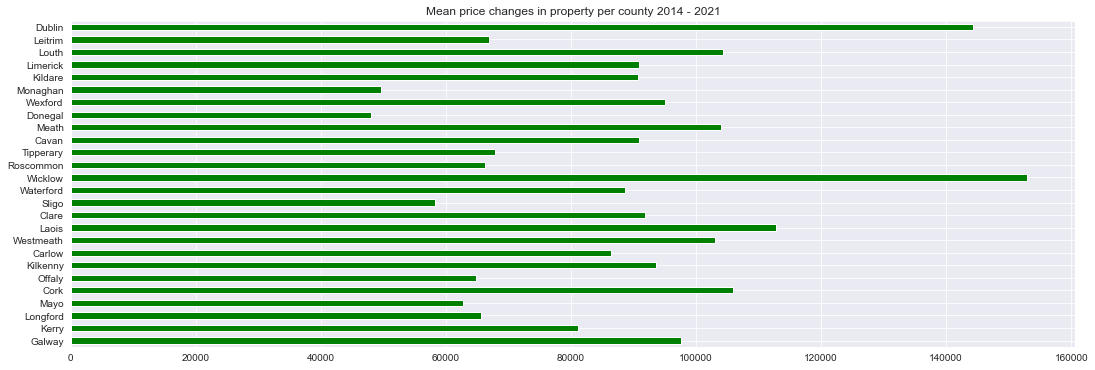

In [54]:
changes1['Change'].plot(kind='barh', color = changes1.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Mean price changes in property per county 2014 - 2021')

In [55]:
d2 = {}
# 2013 nadir normal price, 2014 nadir adjusted prices
for i in range(len(counties)):
    maxv = grouped_county.loc[(grouped_county['County'] == counties[i]) & (grouped_county['Year'] == 2021) ,'PriceInflation'].item()
    minv = grouped_county.loc[(grouped_county['County'] == counties[i]) & (grouped_county['Year'] == 2014) ,'PriceInflation'].item()
    change =  maxv - minv
    d2[counties[i]] = change

In [56]:
changesinf = pd.DataFrame.from_dict(d2, orient='index')
#changes = changes.reset_index()
changesinf = changesinf.rename(columns={0: 'Change'})
changesinf['positive'] = changesinf['Change'] > 0

<AxesSubplot:title={'center':'Mean price changes adjusted for inflation in property per county 2014 - 2021'}>

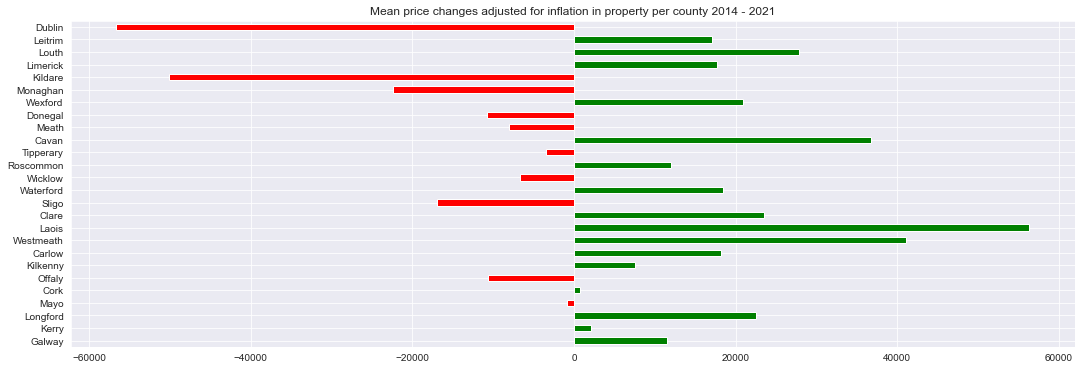

In [57]:
changesinf['Change'].plot(kind='barh', color = changesinf.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Mean price changes adjusted for inflation in property per county 2014 - 2021')

#### Let's do the same for towns now and see the towns that have seen prices surge

In [58]:
grouped_town = house1.groupby(['Town','Year']).agg({'PriceInflation':['mean', 'median'], 'Price (€)': ['mean', 'median']}).reset_index()
grouped_town.columns = ['Town', 'Year', 'InfMean', 'InfMed', 'PriceMean', 'PriceMedian']

In [59]:
# make sure properties sold in both years
three_towns = grouped_town.loc[(grouped_town['Year'] == 2013)]
twentythir = list(set(three_towns['Town']))

four_towns = grouped_town.loc[(grouped_town['Year'] == 2014)]
twentyfour = list(set(four_towns['Town']))

t1_towns = grouped_town.loc[(grouped_town['Year'] == 2021)]
twenty1 = list(set(t1_towns['Town']))

In [60]:
towns = list(set(grouped_town['Town']))
d_towns = {}
# 2013 nadir normal price, 2014 nadir adjusted prices
for i in range(len(towns)):
    if towns[i] in twentyfour and towns[i] in twenty1:
        maxv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2021) ,'PriceMean'].item()
        minv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2014) ,'PriceMean'].item()
        change =  maxv - minv
        d_towns[towns[i]] = change
    else:
        continue

In [61]:
changes2 = pd.DataFrame.from_dict(d_towns, orient='index')
#changes = changes.reset_index()
changes2 = changes2.rename(columns={0: 'Change'})
changes2['positive'] = changes2['Change'] > 0

In [62]:
des_change2 = changes2.sort_values('Change', ascending = False)[:30]
asc_change2 = changes2.sort_values('Change', ascending = True)[:30]

<AxesSubplot:title={'center':'Mean price rises in property for top 30 towns 2014 - 2021'}>

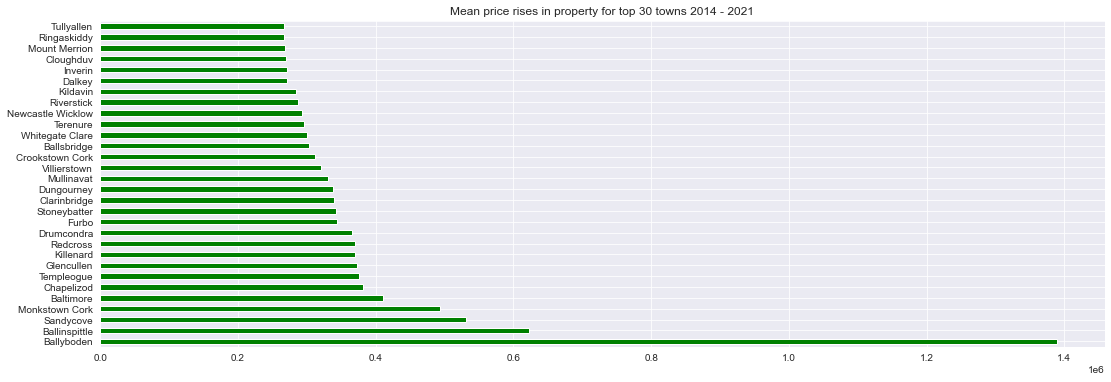

In [63]:
des_change2['Change'].plot(kind='barh', color = des_change2.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Mean price rises in property for top 30 towns 2014 - 2021')

<AxesSubplot:title={'center':'Mean price falls in property for bottom 30 towns 2014 - 2021'}>

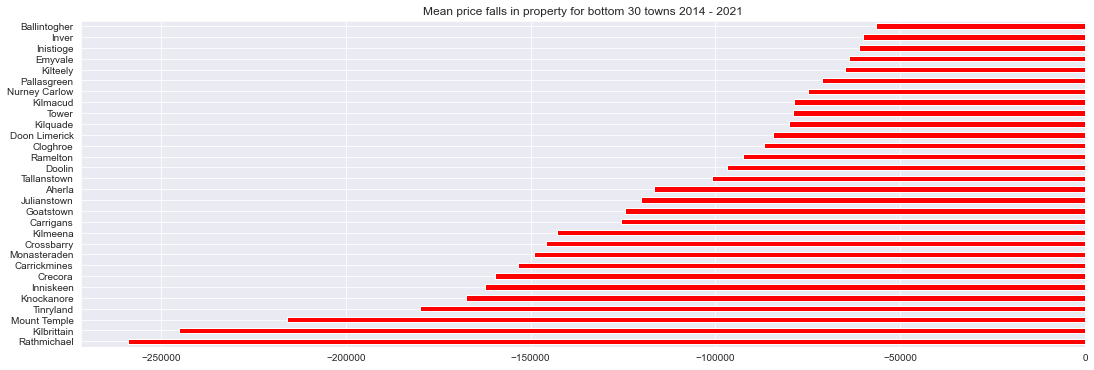

In [64]:
asc_change2['Change'].plot(kind='barh', color = asc_change2.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Mean price falls in property for bottom 30 towns 2014 - 2021')

In [65]:
towns = list(set(grouped_town['Town']))
d_towns_med = {}
# 2013 nadir normal price, 2014 nadir adjusted prices
for i in range(len(towns)):
    if towns[i] in twentyfour and towns[i] in twenty1:
        maxv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2021) ,'PriceMedian'].item()
        minv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2014) ,'PriceMedian'].item()
        change =  maxv - minv
        d_towns_med[towns[i]] = change
    else:
        continue

In [66]:
changes3 = pd.DataFrame.from_dict(d_towns_med, orient='index')
#changes = changes.reset_index()
changes3 = changes3.rename(columns={0: 'Change'})
changes3['positive'] = changes3['Change'] > 0

In [67]:
des_change3 = changes3.sort_values('Change', ascending = False)[:30]
asc_change3 = changes3.sort_values('Change', ascending = True)[:30]

<AxesSubplot:title={'center':'Median price rises (€ Million) in property for top 30 towns 2014 - 2021'}>

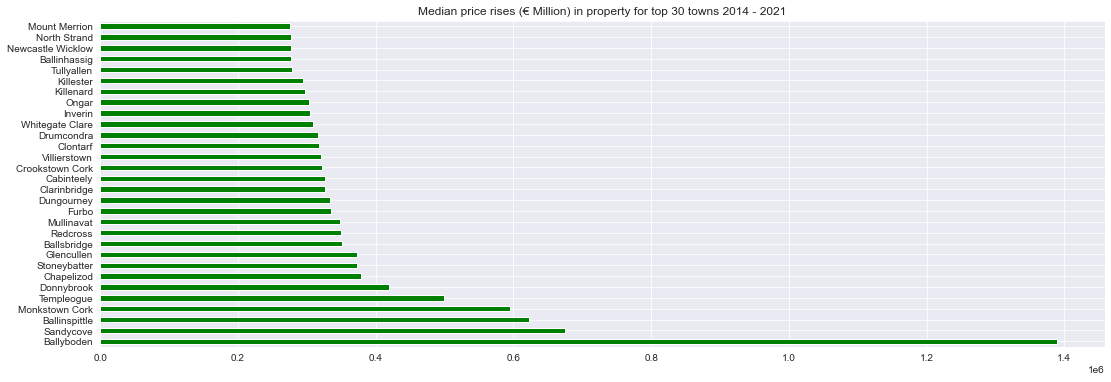

In [68]:
des_change3['Change'].plot(kind='barh', color = des_change3.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Median price rises (€ Million) in property for top 30 towns 2014 - 2021')

<AxesSubplot:title={'center':'Median price falls in property for bottom 30 towns 2014 - 2021'}>

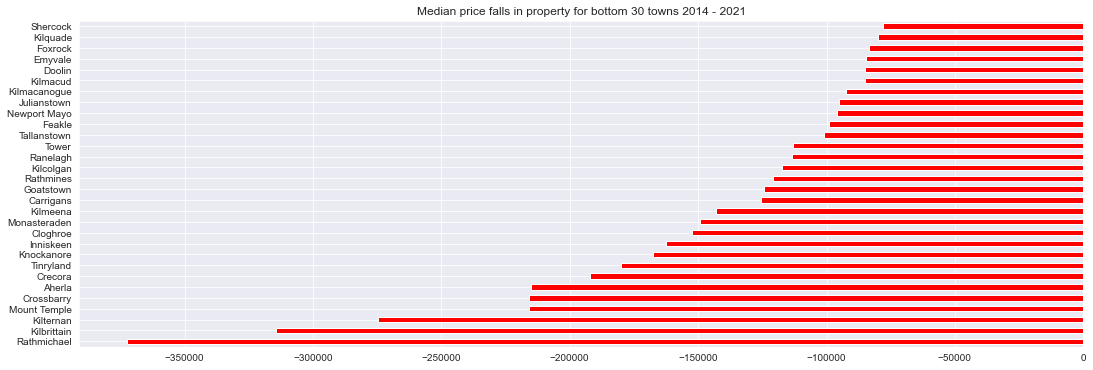

In [69]:
asc_change3['Change'].plot(kind='barh', color = asc_change3.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Median price falls in property for bottom 30 towns 2014 - 2021')

### Let's now do this for inflation adjusted prices

In [70]:
towns = list(set(grouped_town['Town']))
d_towns_infmea = {}
# 2013 nadir normal price, 2014 nadir adjusted prices
for i in range(len(towns)):
    if towns[i] in twentyfour and towns[i] in twenty1:
        maxv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2021) ,'InfMean'].item()
        minv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2014) ,'InfMean'].item()
        change =  maxv - minv
        d_towns_infmea[towns[i]] = change
    else:
        continue

In [71]:
changes4 = pd.DataFrame.from_dict(d_towns_infmea, orient='index')
#changes = changes.reset_index()
changes4 = changes4.rename(columns={0: 'Change'})
changes4['positive'] = changes4['Change'] > 0

In [72]:
des_change4 = changes4.sort_values('Change', ascending = False)[:30]
asc_change4 = changes4.sort_values('Change', ascending = True)[:30]

<AxesSubplot:title={'center':'Mean price rises (€ Million) adjusted for inflation in property for top 30 towns 2014 - 2021'}>

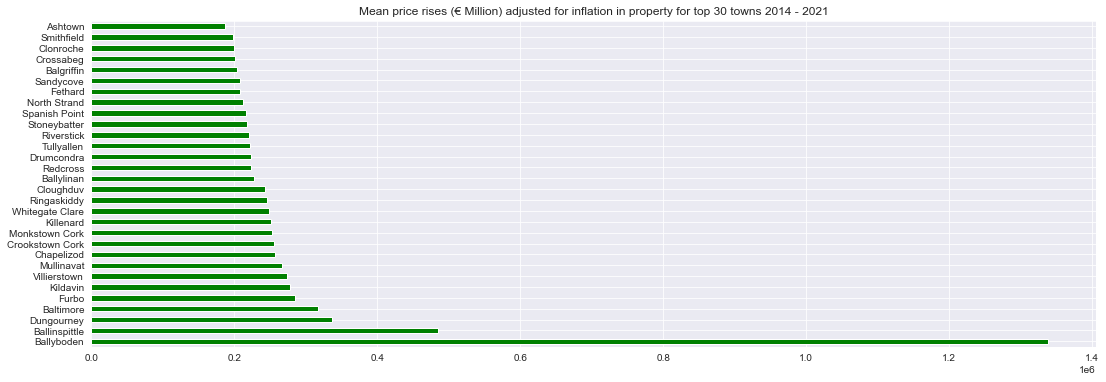

In [73]:
des_change4['Change'].plot(kind='barh', color = des_change4.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Mean price rises (€ Million) adjusted for inflation in property for top 30 towns 2014 - 2021')

<AxesSubplot:title={'center':'Mean price rises adjusted for inflation in property for bottom 30 towns 2014 - 2021'}>

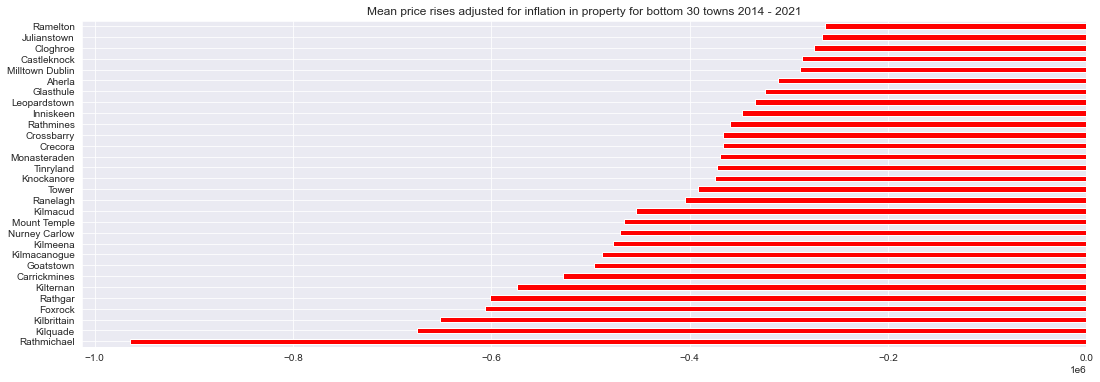

In [74]:
asc_change4['Change'].plot(kind='barh', color = asc_change4.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Mean price rises adjusted for inflation in property for bottom 30 towns 2014 - 2021')

In [75]:
towns = list(set(grouped_town['Town']))
d_towns_infmed = {}
# 2013 nadir normal price, 2014 nadir adjusted prices 
for i in range(len(towns)):
    if towns[i] in twentyfour and towns[i] in twenty1:
        maxv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2021) ,'InfMed'].item()
        minv = grouped_town.loc[(grouped_town['Town'] == towns[i]) & (grouped_town['Year'] == 2014) ,'InfMed'].item()
        change =  maxv - minv
        d_towns_infmed[towns[i]] = change
    else:
        continue

In [76]:
changes5 = pd.DataFrame.from_dict(d_towns_infmed, orient='index')
#changes = changes.reset_index()
changes5 = changes5.rename(columns={0: 'Change'})
changes5['positive'] = changes5['Change'] > 0

des_change5 = changes5.sort_values('Change', ascending = False)[:30]
asc_change5 = changes5.sort_values('Change', ascending = True)[:30]

<AxesSubplot:title={'center':'Median price rises (€ Million) adjusted for inflation in property for top 30 towns 2014 - 2021'}>

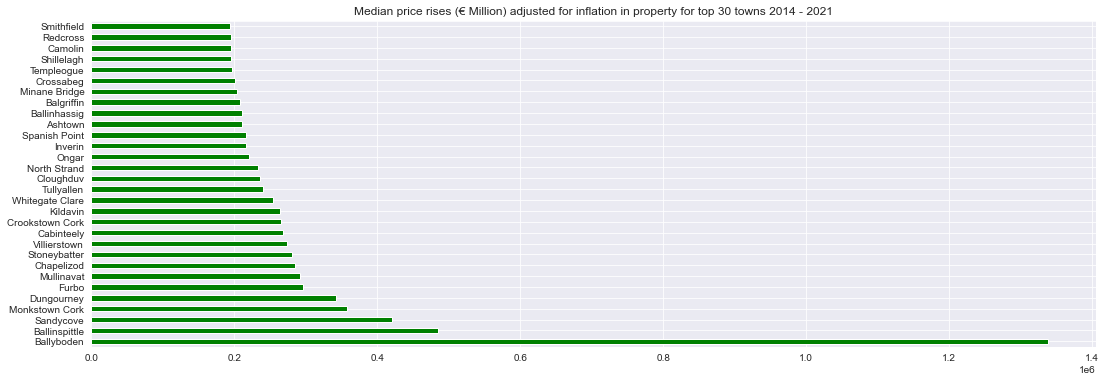

In [77]:
des_change5['Change'].plot(kind='barh', color = des_change5.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Median price rises (€ Million) adjusted for inflation in property for top 30 towns 2014 - 2021')

<AxesSubplot:title={'center':'Median price falls (€ Million) adjusted for inflation in property for top 30 towns 2014 - 2021'}>

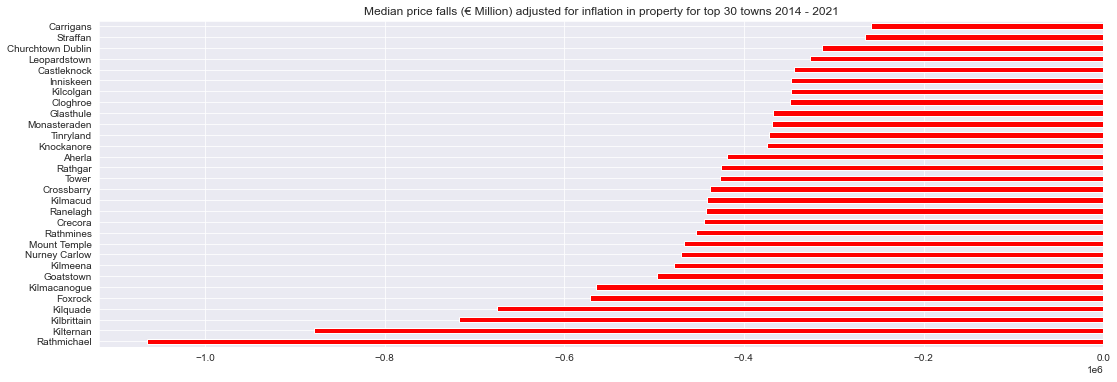

In [78]:
asc_change5['Change'].plot(kind='barh', color = asc_change5.positive.map({True: 'g', False: 'r'}), figsize=(18,6),
                      title = 'Median price falls (€ Million) adjusted for inflation in property for top 30 towns 2014 - 2021')

In [79]:
# seems quite high some of thse values lets double check
grouped_town.loc[grouped_town['Town'] == 'Sandymount'].round()

,Town,Year,InfMean,InfMed,PriceMean,PriceMedian
9756,Sandymount,2010,740669.0,638011.0,511508.0,430000.0
9757,Sandymount,2011,930418.0,873367.0,519830.0,477500.0
9758,Sandymount,2012,918860.0,847554.0,450768.0,413500.0
9759,Sandymount,2013,1161566.0,1057396.0,576056.0,540000.0
9760,Sandymount,2014,932806.0,841058.0,553000.0,515000.0
9761,Sandymount,2015,872284.0,724877.0,570111.0,475000.0
9762,Sandymount,2016,733200.0,684756.0,502484.0,472500.0
9763,Sandymount,2017,832662.0,645439.0,628857.0,482000.0
9764,Sandymount,2018,1010665.0,958404.0,852833.0,823165.0
9765,Sandymount,2019,678872.0,572271.0,588976.0,500000.0


### Observations
While there definitely is some overlap between normal prices and prices adjusted for inflation, we still do see quite a variation in towns here. It is interesting to note the number of towns/areas in Dublin that are near the bottom end for prices adjusted for inflation. There are some what are generally regarded as very wealthy areas such as Sutton and Donnybrook appearing here and it may be worth delving into some of these further. We see some typically rural areas appearing across the board here too such as Glenties, Co.Donegal and Newport in Co. Mayo. The big rises certainly appear to be dispersed around the country with places such as Rosses Point Co.Sligo and Chapelizod in Dublin both featuring in highest mean and median prices both adjusted and not adjusted for inflation. This certainly suggests that properties away from Dublin and more rural are becoming more appealing in the changing working world of working online. It is interesting to note from our earlier breakdown of properties sold per year in our data there was only marginally less sold in 2013 than the data we have up until September 2021.

#### How many towns have seen a positive change in mean/median prices?

<AxesSubplot:title={'center':'Percentage of towns that have seen mean increase in house prices from 2014-2021'}>

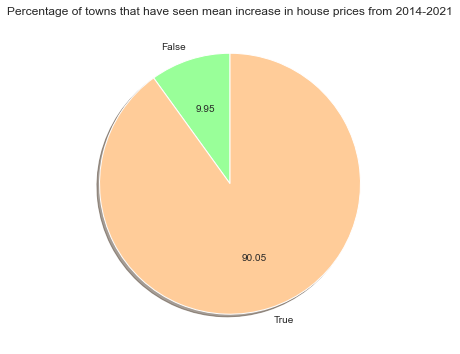

In [80]:
# normal prices
colors = ['#99ff99','#ffcc99']
changes2.groupby('positive').size().plot(kind='pie', autopct='%.2f', colors=colors, figsize=(18,6), startangle=90, shadow = True,
                                        ylabel='',
                                        title='Percentage of towns that have seen mean increase in house prices from 2014-2021')

<AxesSubplot:title={'center':'Percentage of towns that have seen mean increase in house prices adjusted for inflation from 2014-2021'}>

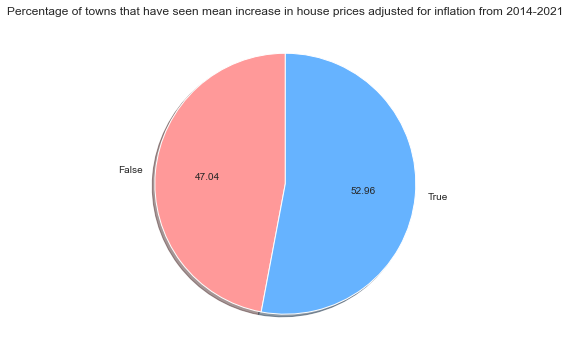

In [81]:
# prices adjusted for inflation
colors1 = ['#ff9999','#66b3ff']
changes4.groupby('positive').size().plot(kind='pie', autopct='%.2f', colors=colors1, figsize=(18,6), startangle=90, shadow = True,
                                        ylabel='',
                                        title='Percentage of towns that have seen mean increase in house prices adjusted for inflation from 2014-2021')

#### Let's investigate a breakdown of the counties with the most towns seeing an increase in mean prices over the period 2013-2021

In [82]:
# adjusted for inflation prices
inflationchange = changes4.loc[changes4['positive'] == True]

In [83]:
inflationchange = inflationchange.reset_index()
inflationchange.rename(columns={'index': 'Town'}, inplace = True)
inflationchange = inflationchange.round()

In [84]:
inflationchange = inflationchange.sort_values(by='Change', ascending=False)

In [85]:
lstinf = list(inflationchange['Town'])

In [86]:
t = house1['County'].groupby(house1['Town']).unique().apply(pd.Series)
t = t.reset_index()
t.rename(columns={0: 'County'}, inplace = True)

In [87]:
join = t.loc[t['Town'].isin(lstinf)]

In [88]:
inflationchange = inflationchange.merge(join)

<AxesSubplot:title={'center':'Number of towns in counties with increase in mean adjusted for inflation 2014-2021'}>

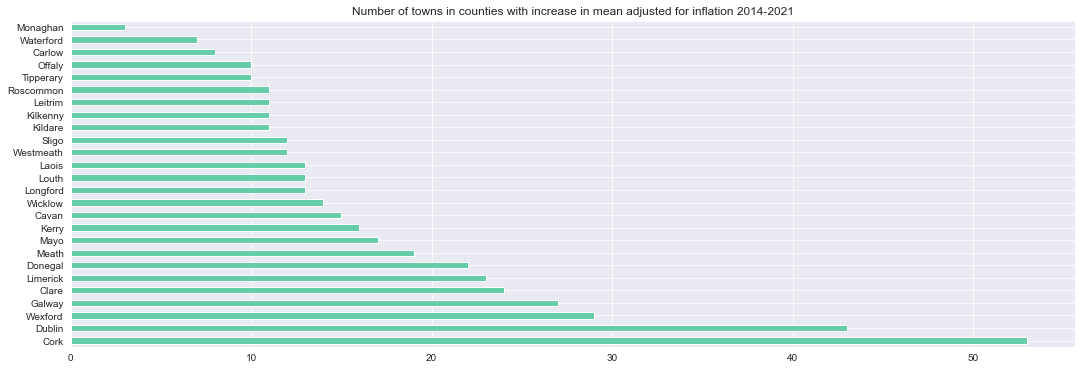

In [89]:
inflationchange['County'].value_counts().plot(kind='barh', figsize=(18,6), color='mediumaquamarine',
                                 title='Number of towns in counties with increase in mean adjusted for inflation 2014-2021')

### Observations
It is no great surprise that Dublin and Cork are the places we see with the largest increases in means here (maybe the order here but point remains). There are 136 unique values (towns) in Dublin in our dataset and 127 towns in our dataset for Cork so these are definitely not insignificant proportions of total towns seeing a mean price increase. However, after this we see some interesting results. Clare, Wexford, Galway and Donegal are all featuring high here (much the same results when we looked at 2013 vs 2021 means). This potentially suggests a few different things here, some of which centre on the new working from home style, all these counties feature extensive coastlines and could hint at holiday homes for example and maybe other socio-economic factors like population increases among others could highlight why these counties feature highly here. This may be something worth devlving deeper into. It might be worth checking the 2019 comparison to 2014 to see did the ongoing pandemic affect this in any way as people worked from home more.

### I will look at what towns actually saw a decrease in real-time mean prices now
Let's focus on the counties these towns are based in.

In [90]:
changes2.shape

(844, 2)

In [91]:
inflationchange.shape

(447, 4)

In [92]:
inflationchange1 = changes4.loc[changes4['positive'] == False]

In [93]:
inflationchange1.shape

(397, 2)

In [94]:
inflationchange1 = inflationchange1.reset_index()
inflationchange1.rename(columns={'index': 'Town'}, inplace = True)
inflationchange1 = inflationchange1.round()

In [95]:
inflationchange1 = inflationchange1.sort_values(by='Change', ascending=False)
lstinf1 = list(inflationchange1['Town'])

In [96]:
t1 = house1['County'].groupby(house1['Town']).unique().apply(pd.Series)
t1 = t1.reset_index()
t1.rename(columns={0: 'County'}, inplace = True)

In [97]:
join1 = t1.loc[t1['Town'].isin(lstinf1)]
inflationchange1 = inflationchange1.merge(join1)

<AxesSubplot:title={'center':'Number of towns in counties with decrease in mean adjusted for inflation 2014-2021'}>

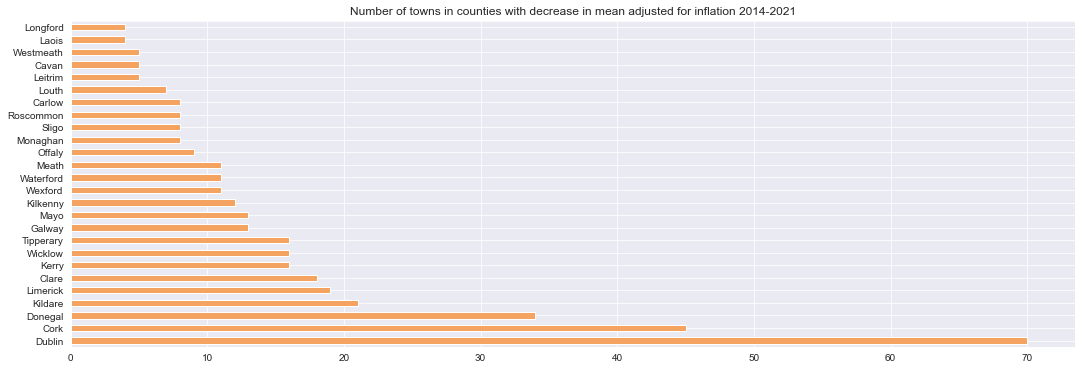

In [98]:
inflationchange1['County'].value_counts().plot(kind='barh', figsize=(18,6), color='sandybrown',
                                 title='Number of towns in counties with decrease in mean adjusted for inflation 2014-2021')

In [99]:
# some barely noticeable changes -> needs addressing
inflationchange1.loc[inflationchange1['County'] == 'Dublin'].head()

,Town,Change,positive,County
21,Lucan,-4177.0,False,Dublin
31,Beaumont,-5140.0,False,Dublin
39,Cabra,-6988.0,False,Dublin
58,Garristown,-9412.0,False,Dublin
94,Clonskeagh,-16838.0,False,Dublin


In [100]:
inflationchange.loc[inflationchange['County'] == 'Dublin'].head(5)

,Town,Change,positive,County
0,Ballyboden,1338087.0,True,Dublin
8,Chapelizod,256533.0,True,Dublin
17,Drumcondra,222844.0,True,Dublin
20,Stoneybatter,217847.0,True,Dublin
22,North Strand,211966.0,True,Dublin


In [101]:
# increase
i = pd.DataFrame(inflationchange['County'].value_counts())
i.rename(columns={'County': 'Towns'}, inplace = True)
i.head(1)

,Towns
Cork,53


In [102]:
#decrease
i2 = pd.DataFrame(inflationchange1['County'].value_counts())
i2.rename(columns={'County': 'Towns'}, inplace = True)
i2.head(1)

,Towns
Dublin,70


### Let's make a choropleth map now of Ireland with our mean increases / decreases for towns in counties
This will give us a better understanding of the importance of location and other factors also.

In [103]:
import geopandas as gpd
ROI_map = gpd.read_file('irl-maps-foldr\counties.shp')  #reading the shape file for our maps 
ROI_map.head(1)

,CO_ID,ENGLISH,GAEILGE,LOGAINM_ID,GUID,CONTAE,COUNTY,PROVINCE,CENTROID_X,CENTROID_Y,AREA,OBJECTID,Shape__Are,Shape__Len,geometry
0,50000,DONEGAL,DÃºn na nGall,100013,2ae19629-1452-13a3-e055-000000000001,DÃºn na nGall,DONEGAL,Ulster,607296.31,911848.45,4.860754e+09,1,4.860148e+09,1.673364e+06,"MULTIPOLYGON (((594771.077 934748.331, 594787...."


In [104]:
# have to make manual lists as df returns null values when trying to merge ROI_map and my other df's
towns = [22, 23, 11, 7, 43, 12, 3, 14, 53, 16, 11, 29, 13, 19, 15, 8, 17, 13, 12, 11, 11, 10, 13, 27, 10, 24]

In [105]:
townsdecrease = [34, 19, 21, 11, 70, 5, 8, 16, 45, 16, 8, 11, 4, 11, 5, 8, 13, 7, 8, 5, 12 , 9, 4, 13, 16, 18]
meanchange = [-10747.900749, 17693.413611, -50079.813111, 18426.963312, -56654.905435, 41058.548941, -22351.045800,
             -6744.849059, 678.929945, 2127.925370, 11947.605356, 20858.160305, 22566.727577, -8046.870838, 36738.864620,
             18242.710109, -820.897635, 27855.933394, -16907.668376, 17038.524485, 7489.460846, -10681.154617, 56371.460304,
             11520.059392, -3521.643042, 23553.695027]

In [106]:
ROI_map = ROI_map.set_index('COUNTY')
df2 = ROI_map.join(i)
df2['COUNTY'] = df2.index
df2.head(3) # this is the new data frame that we created merging the map file and our inflation data

,CO_ID,ENGLISH,GAEILGE,LOGAINM_ID,GUID,CONTAE,PROVINCE,CENTROID_X,CENTROID_Y,AREA,OBJECTID,Shape__Are,Shape__Len,geometry,Towns,COUNTY
COUNTY,,,,,,,,,,,,,,,,
DONEGAL,50000,DONEGAL,DÃºn na nGall,100013,2ae19629-1452-13a3-e055-000000000001,DÃºn na nGall,Ulster,607296.31,911848.45,4.860754e+09,1,4.860148e+09,1.673364e+06,"MULTIPOLYGON (((594771.077 934748.331, 594787....",NaN,DONEGAL
LIMERICK,120000,LIMERICK,Luimneach,100022,2ae19629-1440-13a3-e055-000000000001,Luimneach,Munster,548318.75,640943.05,2.754926e+09,2,2.754890e+09,3.793924e+05,"POLYGON ((565633.820 666243.290, 565697.247 66...",NaN,LIMERICK
KILDARE,80000,KILDARE,Cill Dara,100007,2ae19629-1455-13a3-e055-000000000001,Cill Dara,Leinster,678993.60,712090.40,1.694083e+09,3,1.694124e+09,2.924711e+05,"POLYGON ((700193.727 734740.683, 700317.074 73...",NaN,KILDARE


In [107]:
df2['Towns'] = towns
df2['TownsDecrease'] = townsdecrease
df2['MeanIncrease'] = meanchange

In [108]:
df2.head(1)

,CO_ID,ENGLISH,GAEILGE,LOGAINM_ID,GUID,CONTAE,PROVINCE,CENTROID_X,CENTROID_Y,AREA,OBJECTID,Shape__Are,Shape__Len,geometry,Towns,COUNTY,TownsDecrease,MeanIncrease
COUNTY,,,,,,,,,,,,,,,,,,
DONEGAL,50000,DONEGAL,DÃºn na nGall,100013,2ae19629-1452-13a3-e055-000000000001,DÃºn na nGall,Ulster,607296.31,911848.45,4.860754e+09,1,4.860148e+09,1.673364e+06,"MULTIPOLYGON (((594771.077 934748.331, 594787....",22,DONEGAL,34,-10747.900749


Text(0.9, 0.65, 'Towns Per County Mean Price Increase')

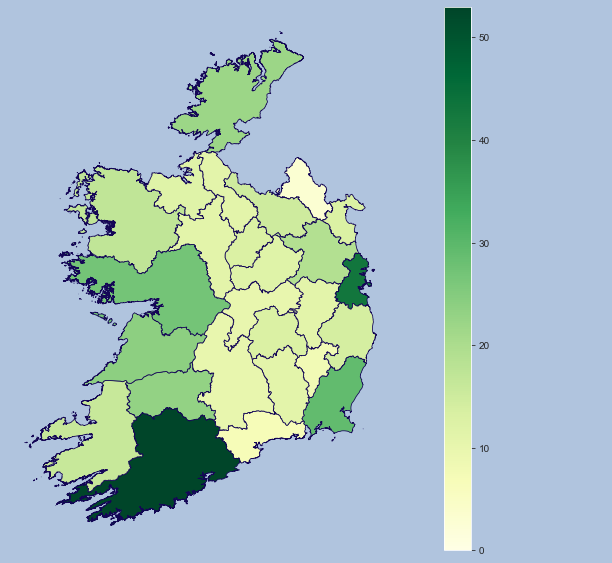

In [109]:
# Chloropleth of Ireland
vmin, vmax = 0, df2['Towns'].max() #Range of Towns value counts used as map colour
fig, ax = plt.subplots(figsize=(18,10),facecolor='lightsteelblue')
fig = df2.plot(column = 'Towns', cmap = 'YlGn', linewidth = 0.8, ax = ax, edgecolor ='#140656', facecolor = 'lightslategray', vmin = vmin, vmax=vmax,
legend = True, norm = plt.Normalize(vmin = vmin, vmax = vmax))
ax.axis('off')

ax.annotate('Towns Per County Mean Price Increase', xy = (0.9, .65), rotation = 270, xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', fontsize = 12, color = 'black')

#### Observations on our chloropleth looking at the number of towns per county with increased mean prices

Looking at this map we can see the two counties with the largest population bases obviously stand out (Dublin and Cork). However, we can also see other trends here I feel. Looking at this map some of the counties with darker colours (towns with more of an increase) there appears to be a trend in that these counties have coastlines, such as Donegal, Clare and Wexford here and that they may not be typical work centres in the Republic of Ireland (like the counties just mentioned). It might be interesting to delve into these counties and observe are these increases in some of the larger towns within these counties or are we seeing a spike in demand for rural housing here. I feel this can be seen further when we look at the midlands / mid-west here and see that these show much lower values as per the colours on our legend above.

#### Let's look at these as a percentage of the number of towns in each county now

In [110]:
vals = list(set(house1['County']))
d_percent = {}
for i in range(len(vals)):
    val = house1.loc[house1['County'] == vals[i]]
    #print(vals[i])
    d_percent[vals[i]] = len(list(set(val['Town'])))

In [111]:
d_percent

{'Galway': 56,
 'Kerry': 52,
 'Mayo': 39,
 'Longford': 21,
 'Cork': 129,
 'Offaly': 26,
 'Kilkenny': 40,
 'Carlow': 21,
 'Westmeath': 26,
 'Laois': 31,
 'Clare': 57,
 'Sligo': 34,
 'Waterford': 32,
 'Wicklow': 42,
 'Roscommon': 35,
 'Tipperary': 49,
 'Cavan': 24,
 'Meath': 42,
 'Donegal': 72,
 'Wexford': 61,
 'Monaghan': 19,
 'Kildare': 45,
 'Limerick': 65,
 'Louth': 22,
 'Leitrim': 25,
 'Dublin': 136}

In [112]:
notowns = [72, 65, 43, 32, 136, 26, 19, 41, 127, 52, 35, 61, 21, 42, 24, 21, 39, 21, 34, 27, 40, 26, 31, 55, 49, 57]
df2['NoTowns'] = notowns

In [113]:
towns = np.array(df2['NoTowns'])
increase = np.array(df2['Towns'])
l = []
for i in range(len(towns)):
    num = increase[i] / towns[i]
    num = num * 100
    l.append(num)

In [114]:
df2['Percentage'] = l

Text(0.9, 0.65, 'Percentage of towns per County with price increase 2014-2021')

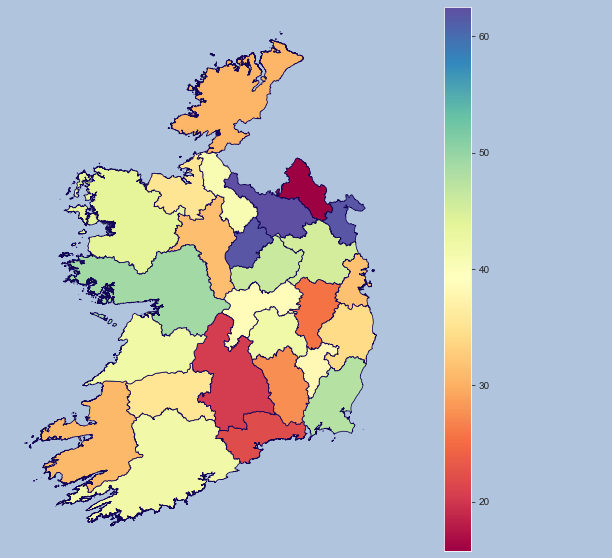

In [115]:
vmin, vmax = df2['Percentage'].min(), df2['Percentage'].max() #Range of Towns value counts used as map colour
fig, ax = plt.subplots(figsize=(18,10),facecolor='lightsteelblue')
fig = df2.plot(column = 'Percentage', cmap = 'Spectral', linewidth = 0.8, ax = ax, edgecolor ='#140656', facecolor = 'lightslategray', vmin = vmin, vmax=vmax,
legend = True, norm = plt.Normalize(vmin = vmin, vmax = vmax))
ax.axis('off')

ax.annotate('Percentage of towns per County with price increase 2014-2021', xy = (0.9, .65), rotation = 270, xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', fontsize = 12, color = 'black')

#### Let's look at mean price changes from 2014 to 2021 on a map now

Text(0.9, 0.65, 'Towns Per County Mean Price Decrease 2014-2021')

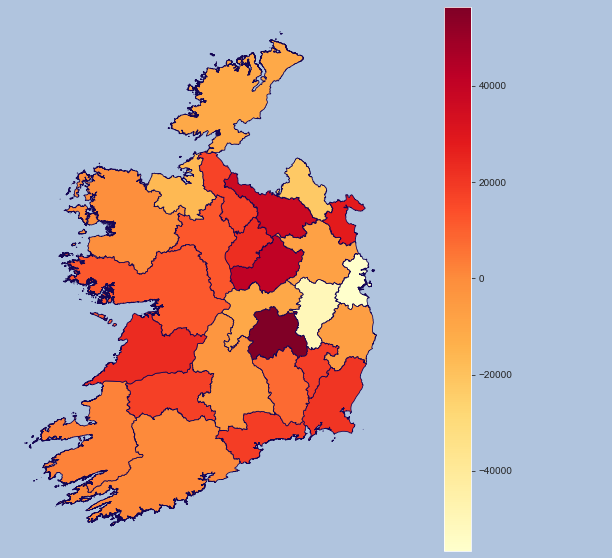

In [116]:
vmin, vmax = changesinf['Change'].min(), changesinf['Change'].max()
fig, ax = plt.subplots(figsize = (18,10),facecolor='lightsteelblue')
fig = df2.plot(column = 'MeanIncrease', cmap = 'YlOrRd', linewidth = 0.8, ax = ax, edgecolor='#140656',facecolor='lightslategray',vmin=vmin, vmax=vmax,
legend = True, norm = plt.Normalize(vmin=vmin, vmax=vmax))
ax.axis('off')

ax.annotate('Towns Per County Mean Price Decrease 2014-2021', xy = (0.9, .65), rotation = 270, xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', fontsize = 12, color = 'black')

#### Let's delve further into our data of increasing means

In [117]:
#inflationchange['County'].value_counts() > 20

In [118]:
#counties = ['Clare', 'Wexford', 'Galway', 'Donegal', 'Limerick']

In [119]:
rural = inflationchange
rural.head()

,Town,Change,positive,County
0,Ballyboden,1338087.0,True,Dublin
1,Ballinspittle,484493.0,True,Cork
2,Dungourney,337190.0,True,Cork
3,Baltimore,316778.0,True,Cork
4,Furbo,284975.0,True,Galway


In [120]:
# let's get rid of very low change values here
rural = rural.loc[rural['Change'] > 5000]

In [121]:
town_map = gpd.read_file('census2011-shapesfiles-towns\Census2011_Settlements.shp')  #reading the shape file for our maps 
town_map.head()

,SETTLEMENT,SETTL_NAME,GEOGID,MALE2011,FEMALE2011,TOTAL2011,PPOCC2011,UNOCC2011,HS2011,VACANT2011,PCVAC2011,AREA2011,POPDENSITY,CREATEDATE,geometry
0,18031,Conna,T18031,226.0,244.0,470.0,166.0,33.0,199.0,33.0,16.6,0.56,833.0,27-03-2012,"POLYGON ((192738.673 92930.309, 192750.473 929..."
1,14042,Ballymurn,T14042,208.0,256.0,464.0,160.0,37.0,197.0,26.0,13.2,0.27,1712.0,27-03-2012,"POLYGON ((303969.008 133121.353, 303972.104 13..."
2,33054,Kildrum,T33054,290.0,291.0,581.0,201.0,36.0,237.0,31.0,13.1,0.52,1115.0,27-03-2012,"POLYGON ((237623.812 414593.665, 237575.199 41..."
3,15025,Shillelagh,T15025,172.0,169.0,341.0,128.0,32.0,160.0,29.0,18.1,0.59,581.0,27-03-2012,"POLYGON ((298490.247 168115.101, 298557.422 16..."
4,23006,Killenaule,T23006,346.0,367.0,713.0,278.0,71.0,349.0,64.0,18.3,0.67,1059.0,27-03-2012,"POLYGON ((221774.782 146278.825, 221777.862 14..."


In [122]:
rural_drop = rural.drop(columns=['positive'])

In [123]:
#list(set(rural_drop['Town']))

In [124]:
rural_drop.head()

,Town,Change,County
0,Ballyboden,1338087.0,Dublin
1,Ballinspittle,484493.0,Cork
2,Dungourney,337190.0,Cork
3,Baltimore,316778.0,Cork
4,Furbo,284975.0,Galway


In [125]:
rural_drop.loc[rural_drop['Town'].str.contains("Whitegate Clare"), 'Town'] = 'Whitegate'
rural_drop.loc[rural_drop['Town'].str.contains('Milford Donegal'), 'Town'] = 'Milford'
rural_drop.loc[rural_drop['Town'].str.contains('Ardagh Limerick'), 'Town'] = 'Ardagh'
rural_drop.loc[rural_drop['Town'].str.contains('Broadford Clare'), 'Town'] = 'Broadfoot'
rural_drop.loc[rural_drop['Town'].str.contains('Ballingarry Limerick'), 'Town'] = 'Ballingarry'
rural_drop.loc[rural_drop['Town'].str.contains('Carraroe Galway'), 'Town'] = 'Carraroe'
rural_drop.loc[rural_drop['Town'].str.contains('Raheen Limerick'), 'Town'] = 'Raheen'
rural_drop.loc[rural_drop['Town'].str.contains('Corofin Galway'), 'Town'] = 'Corofin'

In [126]:
rural_drop.head()

,Town,Change,County
0,Ballyboden,1338087.0,Dublin
1,Ballinspittle,484493.0,Cork
2,Dungourney,337190.0,Cork
3,Baltimore,316778.0,Cork
4,Furbo,284975.0,Galway


In [127]:
town_map = town_map.loc[town_map['SETTL_NAME'].isin(list(rural_drop['Town']))]

In [128]:
rural_drop = rural_drop.loc[rural_drop['Town'].isin(list(town_map['SETTL_NAME']))]

In [129]:
rural_drop1 = rural_drop.set_index('Town')

In [130]:
town_map = town_map.set_index('SETTL_NAME')
df3 = town_map.join(rural_drop1)
df3['SETTL_NAME'] = df3.index
df3.head(3)

,SETTLEMENT,GEOGID,MALE2011,FEMALE2011,TOTAL2011,PPOCC2011,UNOCC2011,HS2011,VACANT2011,PCVAC2011,AREA2011,POPDENSITY,CREATEDATE,geometry,Change,County,SETTL_NAME
Abbeyleix,08001,T08001,906.0,921.0,1827.0,691.0,172.0,863.0,147.0,17.0,3.23,566.0,27-03-2012,"POLYGON ((243408.964 185614.257, 243408.992 18...",74478.0,Laois,Abbeyleix
Allenwood,06030,T06030,419.0,426.0,845.0,266.0,26.0,292.0,25.0,8.6,1.06,799.0,27-03-2012,"POLYGON ((276327.675 226893.173, 276353.733 22...",18845.0,Kildare,Allenwood
Annagassan,10019,T10019,98.0,82.0,180.0,78.0,44.0,122.0,36.0,29.5,0.19,956.0,27-03-2012,"POLYGON ((308579.933 294007.658, 308579.985 29...",36145.0,Louth,Annagassan


In [131]:
#df2.plot(color='white', edgecolor='k')

Text(0.9, 0.65, 'Towns Per County Mean Price Increase')

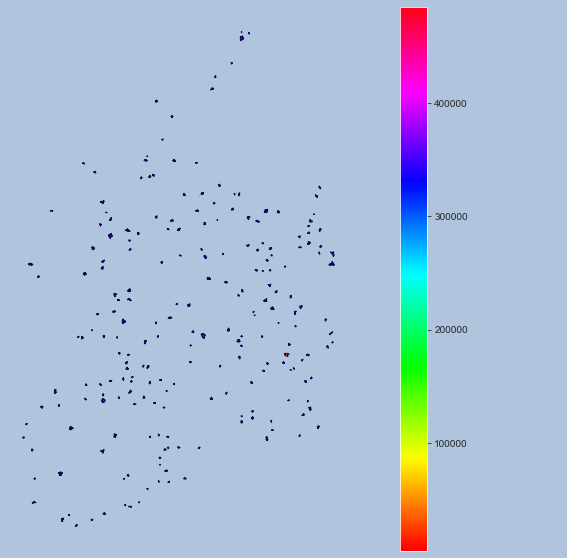

In [132]:
vmin1, vmax1 = df3['Change'].min(), df3['Change'].max()
fig1, ax1 = plt.subplots(figsize = (18, 10), facecolor = 'lightsteelblue')
df3.plot(column = 'Change', cmap = 'hsv', ax = ax1, edgecolor = '#140656', facecolor = 'lightslategray',
legend = True, norm = plt.Normalize(vmin = vmin1, vmax = vmax1), markersize = df3['Change'])
ax1.axis('off')

ax1.annotate('Towns Per County Mean Price Increase', xy = (0.9, .65), rotation = 270, xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', fontsize = 12, color = 'black')

### Let's investigate average number of properties sold each year from 2014-2021 and the number of properties sold per county in this timeframe to give more context to our means and medians

Counties with small numbers sold may be slightly deceptive here.

In [133]:
houseyears = house1.loc[house1['Year'] >= 2014]

In [134]:
val_counts = pd.DataFrame(houseyears['County'].value_counts())
val_counts.rename(columns={'County': 'HousesSold'}, inplace = True)
val_counts.head(1)

,HousesSold
Dublin,38207


In [135]:
built = [6178, 7842, 15409, 6498, 38207, 5250, 1489, 8925, 26965, 7047, 2517, 8358, 1622, 12158, 2986, 2124, 5939, 8030,
        3015, 1535, 3306, 3249, 3817, 7898, 6486, 5540]

In [136]:
#ROI_map = ROI_map.set_index('COUNTY')
df5 = ROI_map.join(val_counts)
df5['COUNTY'] = df5.index
df5['HousesSold'] = built
df5.head(3)

,CO_ID,ENGLISH,GAEILGE,LOGAINM_ID,GUID,CONTAE,PROVINCE,CENTROID_X,CENTROID_Y,AREA,OBJECTID,Shape__Are,Shape__Len,geometry,HousesSold,COUNTY
COUNTY,,,,,,,,,,,,,,,,
DONEGAL,50000,DONEGAL,DÃºn na nGall,100013,2ae19629-1452-13a3-e055-000000000001,DÃºn na nGall,Ulster,607296.31,911848.45,4.860754e+09,1,4.860148e+09,1.673364e+06,"MULTIPOLYGON (((594771.077 934748.331, 594787....",6178,DONEGAL
LIMERICK,120000,LIMERICK,Luimneach,100022,2ae19629-1440-13a3-e055-000000000001,Luimneach,Munster,548318.75,640943.05,2.754926e+09,2,2.754890e+09,3.793924e+05,"POLYGON ((565633.820 666243.290, 565697.247 66...",7842,LIMERICK
KILDARE,80000,KILDARE,Cill Dara,100007,2ae19629-1455-13a3-e055-000000000001,Cill Dara,Leinster,678993.60,712090.40,1.694083e+09,3,1.694124e+09,2.924711e+05,"POLYGON ((700193.727 734740.683, 700317.074 73...",15409,KILDARE


Text(0.9, 0.65, 'Number of Houses Sold in each County 2014-2021')

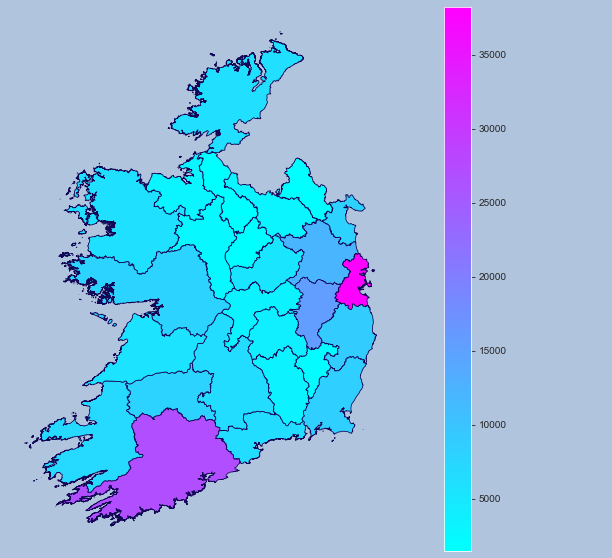

In [137]:
# Chloropleth of number of houses sold in each county during period 2014-21
vmin, vmax = df5['HousesSold'].min(), df5['HousesSold'].max()
fig, ax = plt.subplots(figsize=(18,10),facecolor='lightsteelblue')
fig = df5.plot(column = 'HousesSold', cmap = 'cool', linewidth = 0.8, ax = ax, edgecolor ='#140656', facecolor = 'lightslategray', vmin = vmin, vmax=vmax,
legend = True, norm = plt.Normalize(vmin = vmin, vmax = vmax))
ax.axis('off')

ax.annotate('Number of Houses Sold in each County 2014-2021', xy = (0.9, .65), rotation = 270, xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', fontsize = 12, color = 'black')

### Observations

Obviously, the two counties with the largest population bases are quite clearly ahead here. We also see the commuter belt counties mentioned earlier with noticeably higher numbers of houses sold here. We can see that in general in the border, midlands and mid-west region we can see lower numbers of houses sold here. Looking at some of the counties we focused on earlier, namely Clare, Wexford, Donegal, Limerick and Galway we see that these do have higher numbers of houses sold here that the aforementioned regions. While some of these do possess larger population bases some would possess a large rural area and be further away from traditional centers of work such as Dublin or Cork. This graphic to me definitely illustrates that there appears to be a demand here in some of these counties to get further away from these work centers in the post coronavirus world and less office orientated work environment. It may be interesting to delve further into some of these counties further and see the determinants of the house prices here and try to predict them.

In [138]:
out = ['Clare', 'Limerick', 'Wexford', 'Galway', 'Donegal', 'Louth']
check = houseyears.loc[houseyears['County'].isin(out)]

In [139]:
# 2021 data only goes as far as September
#check = check.loc[check['Month'] < 10]

In [140]:
trend = pd.DataFrame(check.groupby(['County', 'Year']).size())
trend = trend.reset_index()

In [141]:
trend.rename(columns={0: 'Sold'}, inplace =True)
trend.head(1)

,County,Year,Sold
0,Clare,2014,648


In [142]:
wex = trend.loc[trend['County'] == 'Wexford']
gway = trend.loc[trend['County'] == 'Galway']
dun = trend.loc[trend['County'] == 'Donegal']
clar = trend.loc[trend['County'] == 'Clare']
lim = trend.loc[trend['County'] == 'Limerick']
# let's look at these two here as they have larger percentages with price increases 
lu = trend.loc[trend['County'] == 'Louth']

C:\Users\user\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


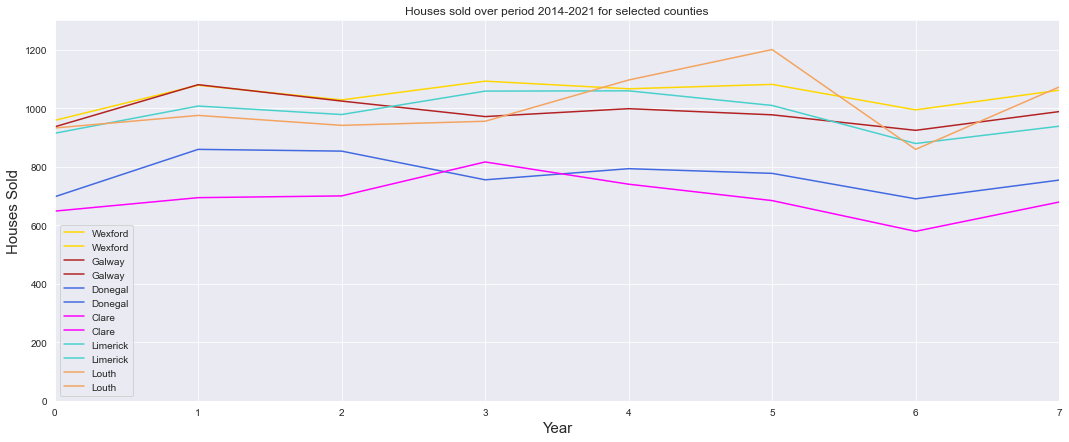

In [143]:
plt.subplots(figsize=(18, 7))
wexf = plt.plot(wex['Sold'].groupby(wex['Year']), label='Wexford', color='gold')
glway = plt.plot(gway['Sold'].groupby(gway['Year']), label='Galway', color='firebrick')
don = plt.plot(dun['Sold'].groupby(dun['Year']), label='Donegal', color='royalblue')
clare = plt.plot(clar['Sold'].groupby(clar['Year']), label='Clare', color='magenta')
limer = plt.plot(lim['Sold'].groupby(lim['Year']), label='Limerick', color='mediumturquoise')
lu1 = plt.plot(lu['Sold'].groupby(lu['Year']), label='Louth', color='sandybrown')
limits = [0, 7, 0, trend['Sold'].max() + 100]
plt.axis(limits)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Houses Sold', fontsize=15)
plt.title('Houses sold over period 2014-2021 for selected counties')
plt.legend()
plt.show()

### Observations from this graph

It is fairly obvious that there is an upward trend here in house sales in these counties. The initial values from 2014 are all lower than the end values in 2021. They all show a sharp rise from 2020 (6) to 2021 (7) after an initial rise from 2014 to 2015 and gradual decrease in the intervening years. It definitely suggests a change in approach from Irish house buyers as what they look for in homes appears to change. Seeing this rise in 2021 is also interesting as the majority of months here would be during harsh restrictions due to covid enforced lockdowns. This even further highlights the change in approach for home owners looking away from Dublin and other commuter based counties. With the exception of Limerick, they all possess coastlines. This may be an interesting avenue to investigate to see does a nearby beach / coast impact sale prices going forward for the Irish buyer. Other locational attributes such as distance to schools etc may be worth investigating too.

In [144]:
counties12 = ['Donegal', 'Galway', 'Clare', 'Wexford', 'Louth', 'Limerick']
coast = house1.loc[house1['County'].isin(counties12)]

coast = coast.loc[coast['Year'] > 2013]

lou = coast.loc[coast['County'] == 'Louth']
done = coast.loc[coast['County'] == 'Donegal']
galw = coast.loc[coast['County'] == 'Galway']
clar = coast.loc[coast['County'] == 'Clare']
limer = coast.loc[coast['County'] == 'Limerick']
wexf = coast.loc[coast['County'] == 'Wexford']

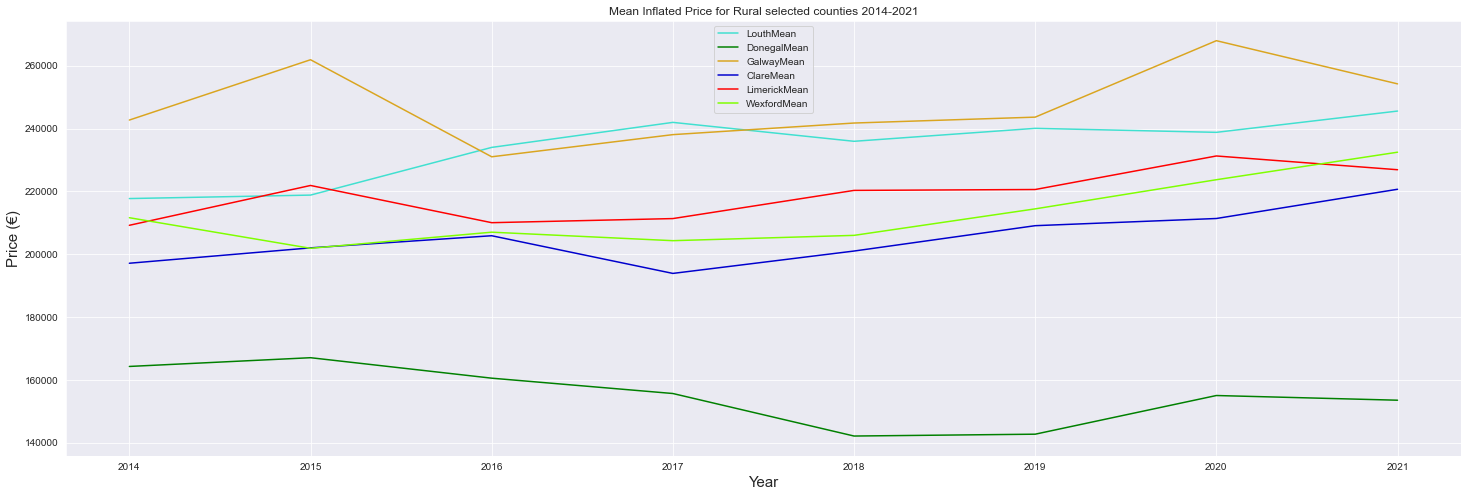

In [145]:
plt.subplots(figsize=(25, 8))
loum = plt.plot(lou['PriceInflation'].groupby(lou['Year']).mean(), label='LouthMean', color='turquoise')
donem = plt.plot(done['PriceInflation'].groupby(done['Year']).mean(), label='DonegalMean', color='green')
galwm = plt.plot(galw['PriceInflation'].groupby(galw['Year']).mean(), label='GalwayMean', color='goldenrod')
clarm = plt.plot(clar['PriceInflation'].groupby(clar['Year']).mean(), label='ClareMean', color='mediumblue')
limerm = plt.plot(limer['PriceInflation'].groupby(limer['Year']).mean(), label='LimerickMean', color='red')
wexfm = plt.plot(wexf['PriceInflation'].groupby(wexf['Year']).mean(), label='WexfordMean', color='chartreuse')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price (€)', fontsize=15)
plt.title('Mean Inflated Price for Rural selected counties 2014-2021')
plt.legend()
plt.show()

### Let's check typically more popular counties to see if there is a definite decrease in house sales in them

In [146]:
out1 = ['Cork', 'Kildare', 'Meath', 'Dublin', 'Wicklow']
check1 = houseyears.loc[houseyears['County'].isin(out1)]

In [147]:
#check1 = check1.loc[check1['Month'] < 10]
trend1 = pd.DataFrame(check1.groupby(['County', 'Year']).size())
trend1 = trend1.reset_index()

In [148]:
trend1.rename(columns={0: 'Sold'}, inplace =True)
trend1.head(1)

,County,Year,Sold
0,Cork,2014,2876


In [149]:
dub1 = trend1.loc[trend1['County'] == 'Dublin']
crk1 = trend1.loc[trend1['County'] == 'Cork']
wick1 = trend1.loc[trend1['County'] == 'Wicklow']
kil1 = trend1.loc[trend1['County'] == 'Kildare']
mea1 = trend1.loc[trend1['County'] == 'Meath']

C:\Users\user\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


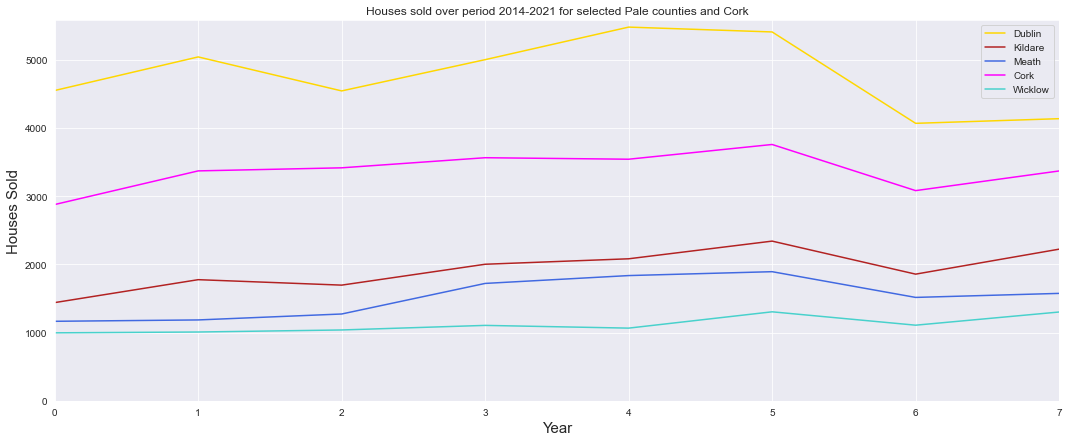

In [150]:
fig, ax = plt.subplots(figsize=(18, 7))
dub = plt.plot(dub1['Sold'].groupby(dub1['Year']), label='Dublin', color='gold')
ax.lines[0].remove() # had weird glitch of all plots with horizontal line going across y=2000 and actual plots then
kil = plt.plot(kil1['Sold'].groupby(kil1['Year']), label='Kildare', color='firebrick')
ax.lines[1].remove()
mea = plt.plot(mea1['Sold'].groupby(mea1['Year']), label='Meath', color='royalblue')
ax.lines[2].remove()
crk = plt.plot(crk1['Sold'].groupby(crk1['Year']), label='Cork', color='magenta')
ax.lines[3].remove()
wick = plt.plot(wick1['Sold'].groupby(wick1['Year']), label='Wicklow', color='mediumturquoise')
ax.lines[4].remove()
limits = [0, 7, 0, trend1['Sold'].max() + 100]
plt.axis(limits)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Houses Sold', fontsize=15)
plt.title('Houses sold over period 2014-2021 for selected Pale counties and Cork')
plt.legend()
plt.show()

In [151]:
counties = ['Meath', 'Kildare', 'Wicklow', 'Cork', 'Dublin']
commuter = house1.loc[house1['County'].isin(counties)]

commuter = commuter.loc[commuter['Year'] > 2013]

dubl = commuter.loc[commuter['County'] == 'Dublin']
meath = commuter.loc[commuter['County'] == 'Meath']
kild = commuter.loc[commuter['County'] == 'Kildare']
wickl = commuter.loc[commuter['County'] == 'Wicklow']
cor = commuter.loc[commuter['County'] == 'Cork']

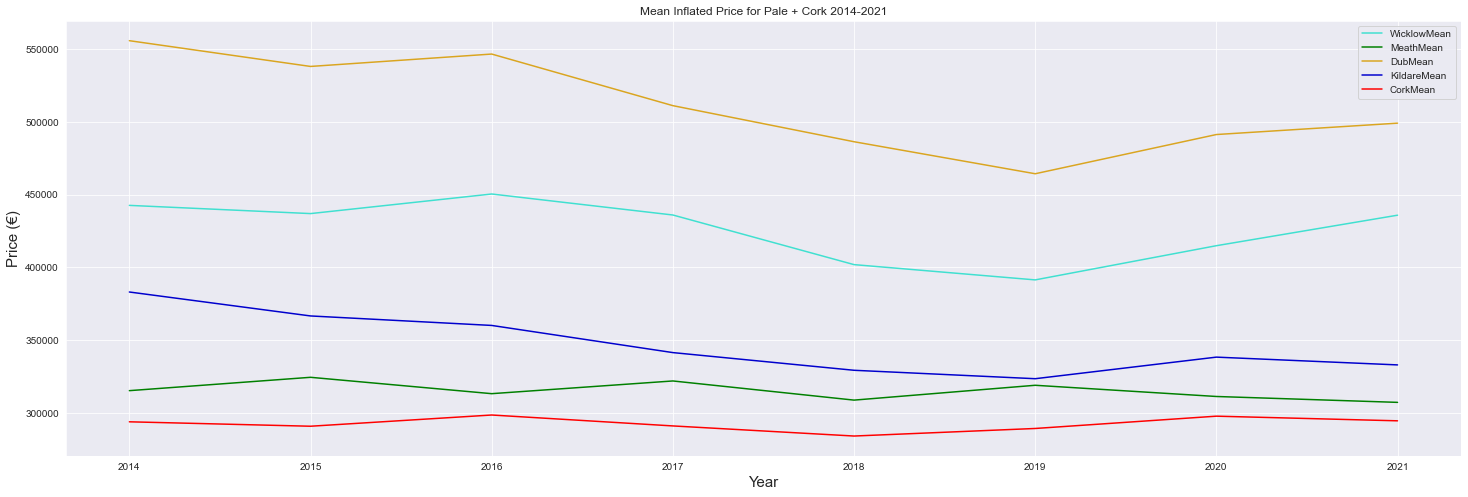

In [152]:
plt.subplots(figsize=(25, 8))
wickm = plt.plot(wickl['PriceInflation'].groupby(wickl['Year']).mean(), label='WicklowMean', color='turquoise')
meathm = plt.plot(meath['PriceInflation'].groupby(meath['Year']).mean(), label='MeathMean', color='green')
dubm = plt.plot(dubl['PriceInflation'].groupby(dubl['Year']).mean(), label='DubMean', color='goldenrod')
kildm = plt.plot(kild['PriceInflation'].groupby(kild['Year']).mean(), label='KildareMean', color='mediumblue')
cordm = plt.plot(cor['PriceInflation'].groupby(cor['Year']).mean(), label='CorkMean', color='red')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price (€)', fontsize=15)
plt.title('Mean Inflated Price for Pale + Cork 2014-2021')
plt.legend()
plt.show()

This is a much sharper rise in contrast to the nationwide mean and median of this time for prices as presented. Even our axis are much higher with values as high as 320,000€ to be seen on the axis also. It is generally agreed that the nadir of housing prices was around 2013 and has seen a rapid rebound since. The median for example here has also doubled, even adjusting for inflation this seems rather high. There is a stark contrast for house price index adjusted prices here. The nadir here appears to be 2014 not 2013 and there is a noticeable downward trend here. This certainly highlights the importance of taking the necessary precautions with our data and not just taking them at face value.

In [182]:
coast1 = coast.loc[coast['County'] != 'Donegal']
vals = list(set(coast1['County']))

In [171]:
#coast1.to_csv('outside-dub-subset.csv')

In [162]:
twn = inflationchange.loc[inflationchange['County'] ==  'Dublin']
twns = list(set(twn['Town']))

In [169]:
dubzz = house1.loc[(house1['Town'].isin(twns)) & (house1['Year'] > 2013)]

In [170]:
#dubzz.to_csv('dublin-subset.csv')

In [180]:
c = inflationchange.loc[inflationchange['County'] == 'Dublin']
#c.to_csv('dub-increases.csv')

In [184]:
z = inflationchange.loc[inflationchange['County'].isin(vals)]
#z.to_csv('Changes-rural.csv')